# Section 1 - Define / Test Ontology Abstractions

## Ontology Superclass Definition

In [5]:
class Ontology:
    def __init__(self):
        self.entity_hierarchy = {}
        self.relationships = []

    def get_entities(self):
        """Returns the entity hierarchy in the ontology."""
        return self.entity_hierarchy
        
    def get_entities_flattened(self):
        """
        Get a flattened list of all entities from the ontology.
        """
        flattened_entities = set(self.entity_hierarchy.keys())  # Include the top-level keys
        for children in self.entity_hierarchy.values():
            flattened_entities.update(children)  # Add all child entities
        return list(flattened_entities)
        
    def get_relationships(self):
        """Returns the relationships in the ontology."""
        return self.relationships
        
    def get_relationship_dataframe(self):
        """
        Creates a DataFrame representation of all relationships in the ontology.

        Returns:
            pd.DataFrame: A DataFrame with columns for subject type, object type, and relation.
        """
        # Create a mapping table
        mapping_table = [
            {"relation": rel, "subj_type": subj, "obj_type": obj}
            for subj, obj, rel in self.get_relationships()
        ]

        # Convert to a DataFrame
        return pd.DataFrame(mapping_table)
        
    def get_triples(self):
        """Returns triples derived from relationships."""
        triples = [
            {"subject": subj, "object": obj, "relation": rel}
            for subj, obj, rel in self.relationships
        ]
        return triples

    def get_sentences_by_docid(self, docid):
        """Returns sentences by docid if supported by the ontology."""
        raise NotImplementedError("This method is not supported for this ontology.")

## TACRED Ontology Subclass Definition

In [6]:
import json
from collections import defaultdict

class TACRED(Ontology):
    def __init__(self, file_paths):
        super().__init__()
        self.file_paths = file_paths
        self.data = self.load_data()
        self.entity_hierarchy = defaultdict(set)
        self.relationships = set()
        self.sentences_by_docid = {}

        self._build_ontology()

    def load_data(self):
        """
        Load TACRED data from one or more JSON files and combine them into a single list.
        """
        combined_data = []
        for file_path in self.file_paths:
            try:
                with open(file_path, 'r') as file:
                    data = json.load(file)
                    combined_data.extend(data)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
        return combined_data

    def _normalize_and_deduplicate_triples(self, triple):
        """
        Normalize and deduplicate triples by converting to lowercase and removing duplicates.
        """
        return {
            "subj": triple["subj"].lower(),
            "subj_type": triple["subj_type"],
            "obj": triple["obj"].lower(),
            "obj_type": triple["obj_type"],
            "relation": triple["relation"],
        }

    def _build_ontology(self):
        """
        Dynamically builds the ontology from TACRED data.
        """

        predefined_hierarchy = {
            "LOCATION": {"CITY", "COUNTRY", "STATE_OR_PROVINCE"},
            "MISC": {"TITLE"},
            "STATE": {"STATE_OR_PROVINCE"},
            "CAUSE": {"CAUSE_OF_DEATH"},
            "CRIMINAL": {"CRIMINAL_CHARGE"},
        }
    
        # Populate the entity hierarchy
        for parent, children in predefined_hierarchy.items():
            self.entity_hierarchy[parent].update(children)
    
        # Extract relationships and sentences
        for record in self.data:
            subj_type = record["subj_type"]
            obj_type = record["obj_type"]
            relation = record["relation"]
    
            # Add entities to hierarchy if not in predefined hierarchy
            if subj_type not in self.entity_hierarchy:
                self.entity_hierarchy["ROOT"].add(subj_type)
            if obj_type not in self.entity_hierarchy:
                self.entity_hierarchy["ROOT"].add(obj_type)
    
            # Add relationships
            if relation != "no_relation":
                self.relationships.add((subj_type, obj_type, relation))
    
            # Map sentences by docid
            docid = record["docid"]
            sentence = " ".join(record["token"])
            triple = self._normalize_and_deduplicate_triples({
                "subj": " ".join(record["token"][record["subj_start"]:record["subj_end"] + 1]),
                "subj_type": record["subj_type"],
                "obj": " ".join(record["token"][record["obj_start"]:record["obj_end"] + 1]),
                "obj_type": record["obj_type"],
                "relation": record["relation"],
            })
    
            # Initialize docid entry if it doesn't exist
            if docid not in self.sentences_by_docid:
                self.sentences_by_docid[docid] = {
                    "tokens": record["token"],
                    "sentence": sentence,
                    "triples": set(),  # Use a set for deduplication
                }
            
            # Add triple to the set (automatic deduplication)
            self.sentences_by_docid[docid]["triples"].add(tuple(triple.items()))  # Store as immutable tuple for set
    
        # Convert triples back to a list of dictionaries for consistency
        for docid, data in self.sentences_by_docid.items():
            data["triples"] = [dict(triple) for triple in data["triples"]]

    def get_entities(self):
        """
        Retrieve the entity hierarchy in a dictionary format.
        """
        return {parent: list(children) for parent, children in self.entity_hierarchy.items()}

    def get_relationships(self):
        """
        Retrieve the list of relationships as triples.
        """
        return list(self.relationships)

    def get_sentences_by_docid(self, docid):
        """
        Retrieve sentence and associated triples for a given docid.
        """
        return self.sentences_by_docid.get(docid, {})

    def get_all_docids(self):
        """
        Retrieve all available docids in the TACRED dataset.
        """
        return list(self.sentences_by_docid.keys())


## TACRED Ontology - Simple Usage Operations

**Important - The tacred_subpath and file paths must reference the TACRED file (e.g., test.json) you wish to process.**

In [7]:
from pprint import pprint

In [8]:
base_experiment_path = '/home/ubuntu'

tacred_subpath = '/dev'

tacred_file_paths = \
    [f"{base_experiment_path}/{tacred_subpath}/test.json"] 

In [9]:
# Load TACRED data
tacred_ontology = TACRED(tacred_file_paths)

# Retrieve entities
entities = tacred_ontology.get_entities()
print("Entities:")
pprint(entities)

Entities:
{'CAUSE': ['CAUSE_OF_DEATH'],
 'CRIMINAL': ['CRIMINAL_CHARGE'],
 'LOCATION': ['STATE_OR_PROVINCE', 'CITY', 'COUNTRY'],
 'MISC': ['TITLE'],
 'ROOT': ['TITLE',
          'PERSON',
          'DURATION',
          'STATE_OR_PROVINCE',
          'IDEOLOGY',
          'CAUSE_OF_DEATH',
          'CITY',
          'NUMBER',
          'NATIONALITY',
          'ORGANIZATION',
          'URL',
          'DATE',
          'COUNTRY',
          'RELIGION',
          'CRIMINAL_CHARGE'],
 'STATE': ['STATE_OR_PROVINCE']}


In [10]:
# Retrieve relationships
relationships = tacred_ontology.get_relationships()
print("\nRelationships:")
for rel in relationships:
    print(f"{rel[0]} -> {rel[2]} -> {rel[1]}")


Relationships:
PERSON -> per:age -> NUMBER
ORGANIZATION -> org:alternate_names -> MISC
ORGANIZATION -> org:members -> COUNTRY
PERSON -> per:cities_of_residence -> CITY
PERSON -> per:city_of_death -> CITY
PERSON -> per:stateorprovinces_of_residence -> STATE_OR_PROVINCE
ORGANIZATION -> org:country_of_headquarters -> COUNTRY
PERSON -> per:origin -> NATIONALITY
PERSON -> per:age -> DURATION
ORGANIZATION -> org:parents -> LOCATION
PERSON -> per:religion -> RELIGION
ORGANIZATION -> org:stateorprovince_of_headquarters -> STATE_OR_PROVINCE
PERSON -> per:country_of_death -> COUNTRY
ORGANIZATION -> org:shareholders -> PERSON
ORGANIZATION -> org:shareholders -> ORGANIZATION
PERSON -> per:children -> PERSON
ORGANIZATION -> org:country_of_headquarters -> LOCATION
PERSON -> per:schools_attended -> ORGANIZATION
PERSON -> per:employee_of -> ORGANIZATION
PERSON -> per:charges -> CRIMINAL_CHARGE
ORGANIZATION -> org:founded -> DATE
PERSON -> per:alternate_names -> PERSON
ORGANIZATION -> org:city_of_head

In [91]:
# Retrieve triples
triples = tacred_ontology.get_triples()
print("\nTriples:")
pprint(triples[:5])  # Print first 5 triples


Triples:
[{'object': 'ORGANIZATION',
  'relation': 'org:parents',
  'subject': 'ORGANIZATION'},
 {'object': 'PERSON', 'relation': 'per:children', 'subject': 'PERSON'},
 {'object': 'CAUSE_OF_DEATH',
  'relation': 'per:cause_of_death',
  'subject': 'PERSON'},
 {'object': 'ORGANIZATION', 'relation': 'per:employee_of', 'subject': 'PERSON'},
 {'object': 'LOCATION',
  'relation': 'per:countries_of_residence',
  'subject': 'PERSON'}]


In [110]:
# Retrieve sentences by docid
docid = "APW_ENG_20100216.0150"  # Example docid
sentence = tacred_ontology.get_sentences_by_docid(docid)
print(f"\nSentence for docid {docid}:")
pprint(sentence)


Sentence for docid APW_ENG_20100216.0150:
{'sentence': 'About four years ago , he emerged in Santo Domingo saying he '
             'wanted to establish a Sephardic Jewish community .',
 'tokens': ['About',
            'four',
            'years',
            'ago',
            ',',
            'he',
            'emerged',
            'in',
            'Santo',
            'Domingo',
            'saying',
            'he',
            'wanted',
            'to',
            'establish',
            'a',
            'Sephardic',
            'Jewish',
            'community',
            '.'],
 'triples': [{'obj': 'his',
              'obj_type': 'PERSON',
              'relation': 'no_relation',
              'subj': 'his',
              'subj_type': 'PERSON'},
             {'obj': 'his',
              'obj_type': 'PERSON',
              'relation': 'no_relation',
              'subj': 'he',
              'subj_type': 'PERSON'},
             {'obj': 'activist',
              'obj_type'

## TACRED Ontology - Simple Data Visualizations

In [111]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd

In [112]:
def plot_relation_frequencies_from_ontology(tacred_instance, include_no_relation=True):
    """
    Plots the frequency of relations in a TACRED ontology instance, 
    with the option to include or exclude 'no_relation'.
    
    Args:
        tacred_instance (TACRED): An instance of the TACRED ontology class.
        include_no_relation (bool): Whether to include 'no_relation' in the visualization.
    """
    # Access the raw TACRED data
    tacred_data = tacred_instance.data

    # Filter data based on 'include_no_relation' flag
    if not include_no_relation:
        filtered_data = [record for record in tacred_data if record["relation"] != "no_relation"]
    else:
        filtered_data = tacred_data

    # Count the frequency of each relation
    relation_counts = Counter(record["relation"] for record in filtered_data)

    # Extract relations and counts
    relations = list(relation_counts.keys())
    counts = list(relation_counts.values())

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(relations, counts)
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Relation")
    plt.ylabel("Number of Records")
    plt.title("Frequency of Relations in TACRED" + (" (Excluding 'no_relation')" if not include_no_relation else ""))
    plt.show()


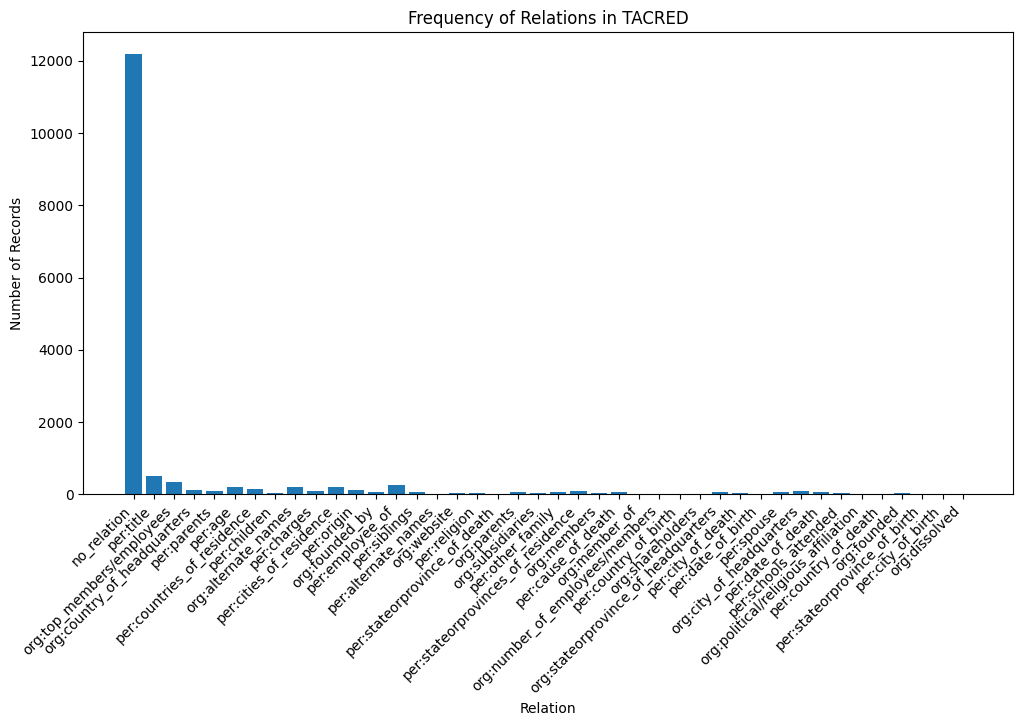

In [95]:
# Plot relation frequencies including 'no_relation'
plot_relation_frequencies_from_ontology(tacred_ontology, include_no_relation=True)

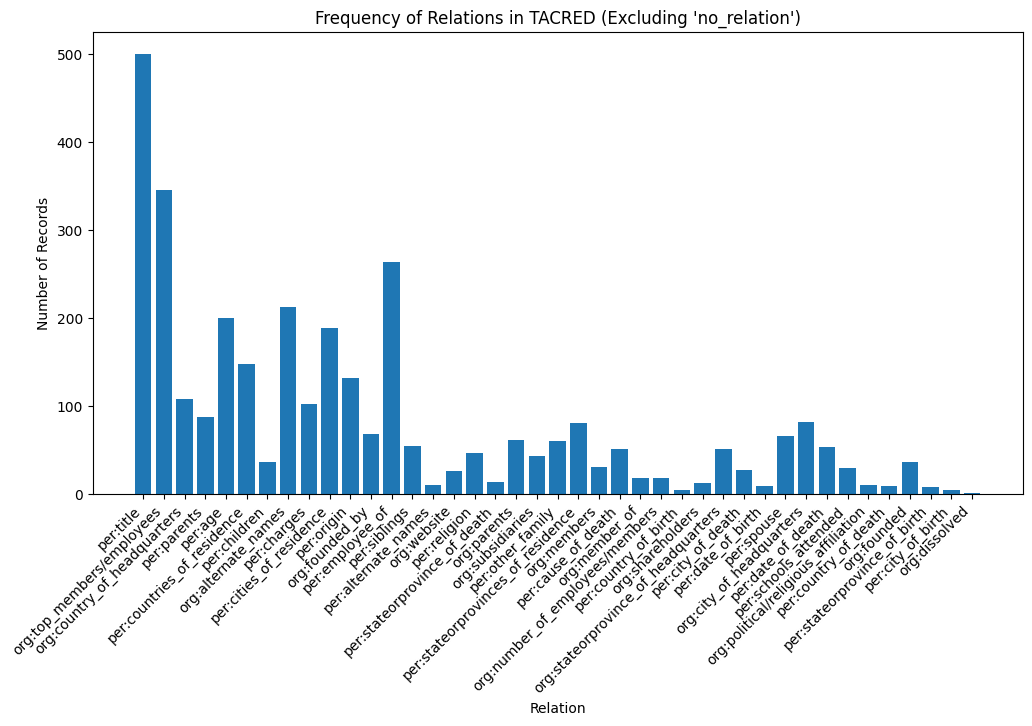

In [113]:
# Now, plot the distribution excluding no_relations, which represent the meaningful ones
plot_relation_frequencies_from_ontology(tacred_ontology, include_no_relation=False)

In [96]:
def plot_subject_object_heatmap(tacred_instance):
    """
    Generates and plots a heatmap of subject-object type relationships from TACRED data.

    Args:
        data (list): List of TACRED records.

    Returns:
        None: Displays the heatmap.
    """
    # Access the raw TACRED data
    tacred_data = tacred_instance.data
    
    # Count subject-object type pairs
    type_pairs = [(record["subj_type"], record["obj_type"]) for record in tacred_data]
    pair_counts = Counter(type_pairs)

    # Create a dataframe for heatmap
    df = pd.DataFrame.from_dict(pair_counts, orient="index", columns=["count"])
    df.reset_index(inplace=True)
    df.columns = ["pair", "count"]

    # Split the tuple 'pair' into 'subj_type' and 'obj_type'
    df[["subj_type", "obj_type"]] = pd.DataFrame(df["pair"].tolist(), index=df.index)
    df.drop(columns=["pair"], inplace=True)

    # Pivot the dataframe for heatmap format
    heatmap_data = df.pivot(index="subj_type", columns="obj_type", values="count").fillna(0).astype(int)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar_kws={"label": "Count"})
    plt.title("Heatmap of Subject-Object Relationships")
    plt.xlabel("Object Type")
    plt.ylabel("Subject Type")
    plt.show()


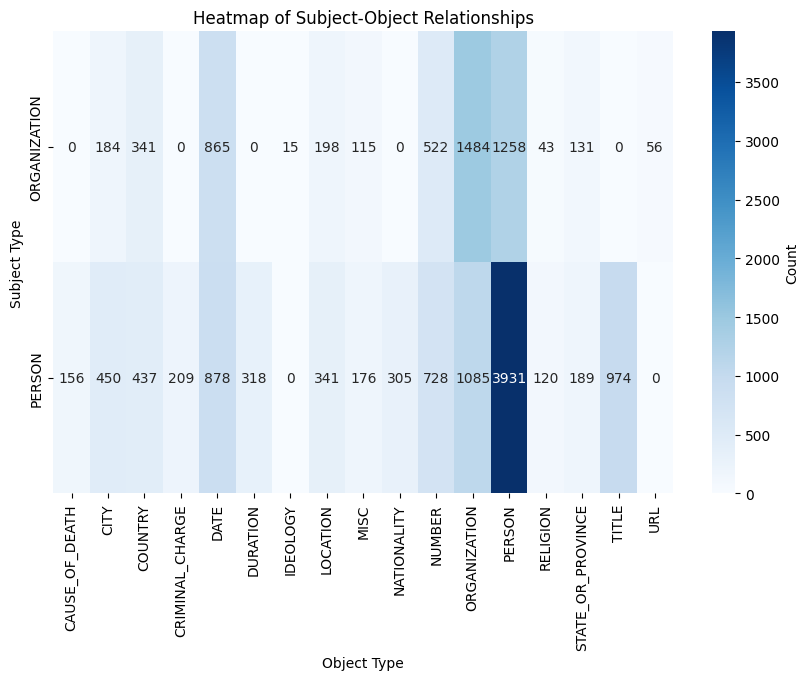

In [114]:
# Entity types within TACRED are ultimately associated with Persons or Organizations.
# Produce a heatmap showing the makeup and relative numbers of those relationships.

plot_subject_object_heatmap(tacred_ontology)

In [115]:
import networkx as nx
import matplotlib.pyplot as plt

def create_entity_hierarchy_graph(entity_hierarchy):
    """
    Create a subgraph for the entity hierarchy with reversed edges and renamed root.

    Args:
        entity_hierarchy (dict): The entity hierarchy mapping.

    Returns:
        nx.DiGraph: A directed graph representing the reversed entity hierarchy.
    """
    G = nx.DiGraph()
    for parent, children in entity_hierarchy.items():
        parent = "Entity" if parent == "ROOT" else parent  # Rename ROOT to Entity
        G.add_node(parent)
        for child in children:
            child = "Entity" if child == "ROOT" else child  # Ensure child renaming
            G.add_node(child)
            G.add_edge(child, parent)  # Reverse the direction of the edge
    return G

def create_relationship_graph(mapping_df):
    """
    Create a subgraph for the relationships.
    
    Args:
        mapping_df (DataFrame): The mapping DataFrame containing relationships.

    Returns:
        nx.DiGraph: A directed graph representing the relationships.
    """
    G = nx.DiGraph()
    for _, row in mapping_df.iterrows():
        G.add_node(row["subj_type"])
        G.add_node(row["obj_type"])
        G.add_edge(row["subj_type"], row["obj_type"], label=row["relation"])
    return G

def visualize_subgraph(G, title="Graph Visualization", layout="kamada_kawai"):
    """
    Visualize a subgraph with a specified layout.
    
    Args:
        G (nx.DiGraph): The graph to visualize.
        title (str): Title for the visualization.
        layout (str): Layout algorithm to use ('spring', 'kamada_kawai', 'circular', etc.).
    """
    # Select layout
    if layout == "spring":
        pos = nx.spring_layout(G, seed=42)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "circular":
        pos = nx.circular_layout(G)
    elif layout == "shell":
        pos = nx.shell_layout(G)
    elif layout == "spectral":
        pos = nx.spectral_layout(G)
    elif layout == "random":
        pos = nx.random_layout(G)
    elif layout == "planar":
        pos = nx.planar_layout(G)
    else:
        raise ValueError(f"Unknown layout: {layout}")
        
    plt.figure(figsize=(16, 12))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="skyblue",
        node_size=3000,
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    edge_labels = {(u, v): d.get("label", "") for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels, font_size=8
    )
    plt.title(title)
    plt.show()

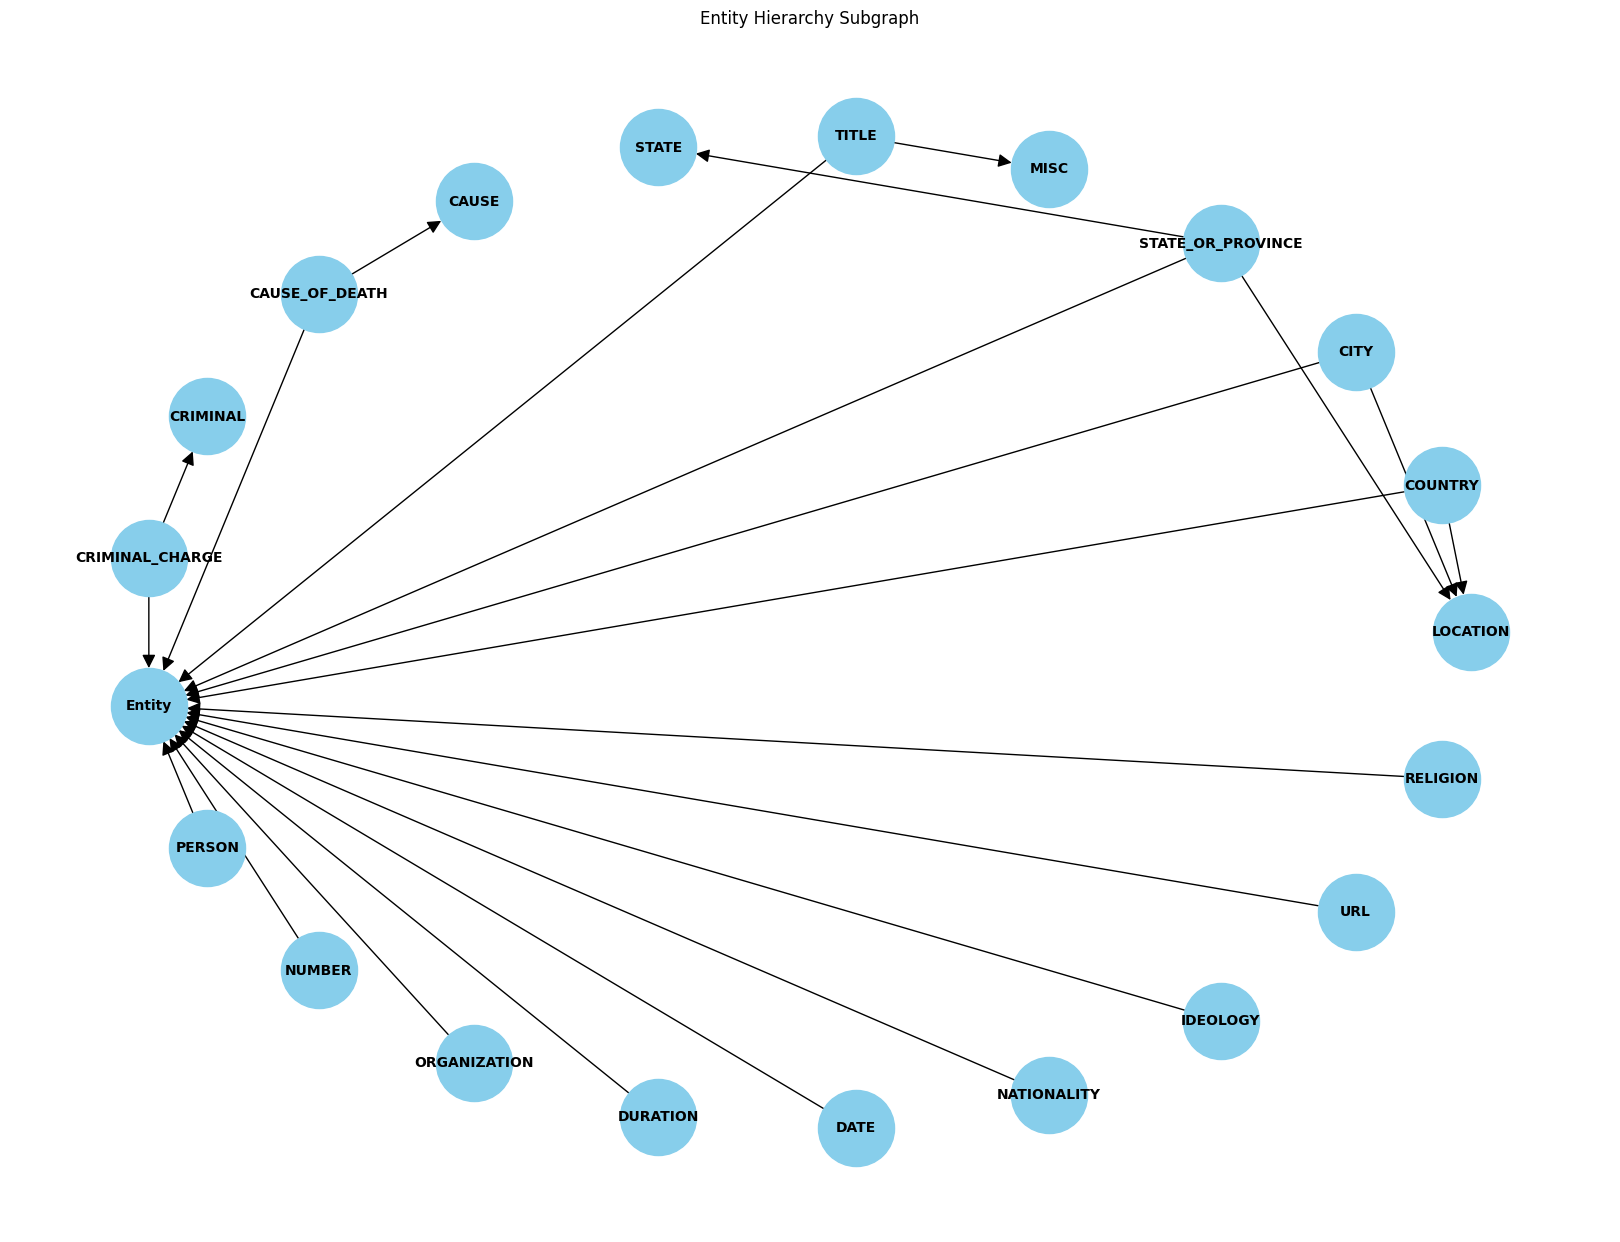

In [23]:
# Visualize Entity Hierarchy Subgraph
entity_hierarchy_graph = create_entity_hierarchy_graph(tacred_ontology.get_entities())
visualize_subgraph(entity_hierarchy_graph, title="Entity Hierarchy Subgraph", layout="circular")

In [116]:
# Generate the relationship DataFrame from the TACRED ontology instance
relationship_df = tacred_ontology.get_relationship_dataframe()

# Filter out 'no_relation' relationships if needed
filtered_relationship_df = relationship_df[relationship_df["relation"] != "no_relation"]

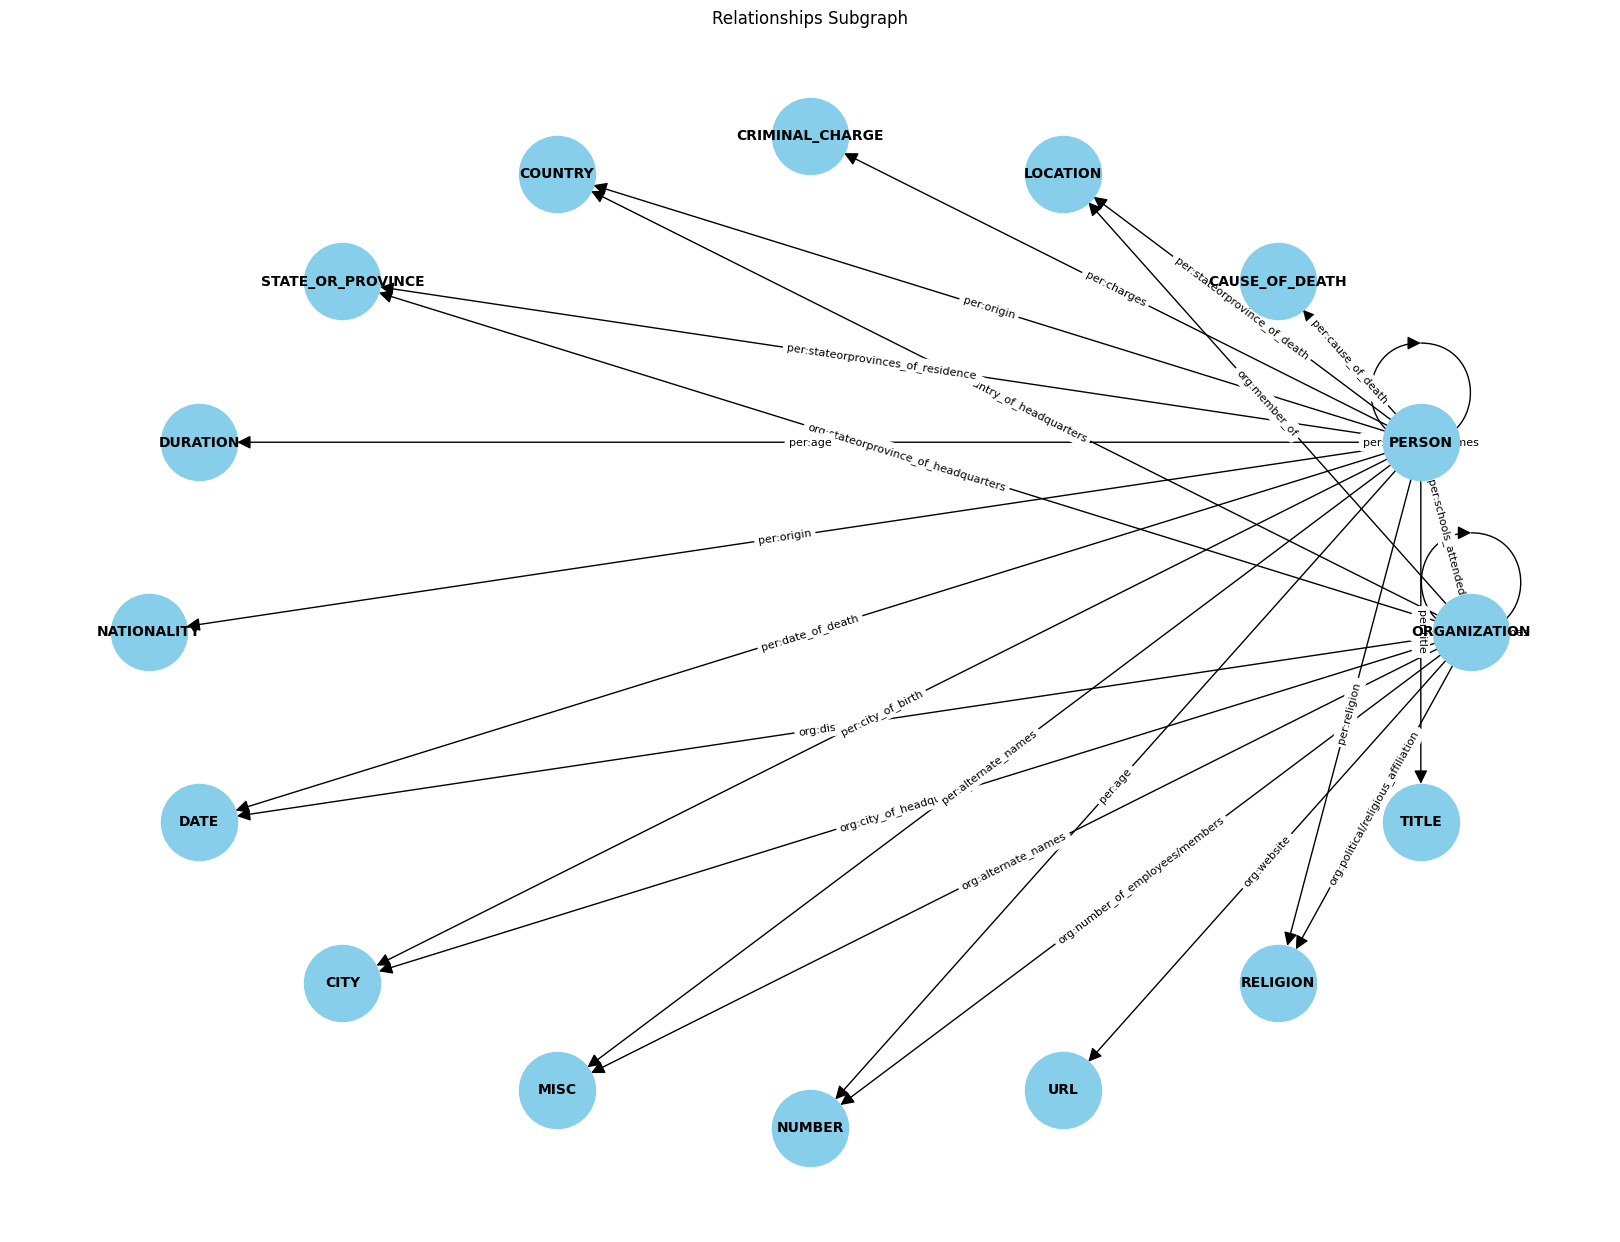

In [117]:
# Visualize Relationships Subgraph
relationship_graph = create_relationship_graph(filtered_relationship_df)
visualize_subgraph(relationship_graph, title="Relationships Subgraph", layout="circular")

# Section 2 - Define / Test Large Language Model (LLM) Abstractions

## LLM Superclass Definition

In [118]:
from abc import ABC, abstractmethod
import openai
from dotenv import load_dotenv
import os

class BaseLanguageModel(ABC):
    """
    Abstract base class for Language Models.
    """
    @abstractmethod
    def __init__(self, **kwargs):
        pass

    @abstractmethod
    def initialize(self):
        """
        Abstract method to handle initialization of the language model (e.g., loading API keys).
        """
        pass

    @abstractmethod
    def prompt(self, prompt_template: str, sentence: str, **kwargs) -> str:
        """
        Sends a prompt to the language model and retrieves a response.
        """
        pass

## OpenAI Subclass Definition

In [119]:
from openai import OpenAI

class OpenAIModel(BaseLanguageModel):
    """
    Implementation for OpenAI GPT models.
    """
    def __init__(self, model: str = "gpt-4", max_tokens: int = 1500, temperature: float = 0.2):
        """
        Initialize the OpenAI model parameters.
        """
        self.model = model
        self.max_tokens = max_tokens
        self.temperature = temperature
        self.initialize()  # Explicitly call initialize during instantiation

    def initialize(self):
        """
        Load OpenAI API key and validate it.
        """
        load_dotenv()
        openai_api_key = os.getenv("OPENAI_API_KEY")
        openai.api_key = openai_api_key

        if openai_api_key is None:
            raise ValueError("OpenAI API key not found in the .env file.")
        
        print("OpenAI API key loaded successfully!")

    def prompt(self, prompt_template: str, sentence: str, **kwargs) -> str:
        """
        Sends a prompt to the OpenAI GPT model.
        """
        try:
            messages = [
                {"role": "system", "content": prompt_template},
                {"role": "user", "content": sentence}
            ]

            client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))
            
            # Allow overriding model parameters
            response = client.chat.completions.create(
                model=kwargs.get("model", self.model),
                messages=messages,
                max_tokens=kwargs.get("max_tokens", self.max_tokens),
                temperature=kwargs.get("temperature", self.temperature),
            )

            # Extract the generated solution from the response
            final_response = response.choices[0].message.content.strip()
            return final_response
        except Exception as e:
            print(f"Error generating solution: {e}")
            return None

## Meta Llama Subclass Definition

In [120]:
from llama_stack_client import LlamaStackClient

class LlamaModel(BaseLanguageModel):
    """
    Implementation for LLaMA models using LlamaStackClient API.
    """
    def __init__(self, base_url: str, model_id: str, temperature: float = 0.6, top_p: float = 0.9, **kwargs):
        """
        Initialize the LLaMA model client.
        
        Args:
            base_url (str): The LlamaStack server endpoint.
            model_id (str): The unique identifier for the model to query.
            temperature (float): Sampling temperature.
            top_p (float): Nucleus sampling top-p value.
        """
        self.base_url = base_url
        self.model_id = model_id
        self.temperature = temperature
        self.top_p = top_p
        self.client = None
        self.initialize()

    def initialize(self):
        """
        Initialize the LlamaStack client.
        """
        try:
            # Create a client to communicate with the LlamaStack server
            self.client = LlamaStackClient(base_url=self.base_url)
            print(f"LlamaStackClient initialized with endpoint: {self.base_url}")
        except Exception as e:
            raise ValueError(f"Failed to initialize LlamaStackClient: {e}")

    def prompt(self, prompt_template: str, sentence: str, **kwargs) -> str:
        """
        Sends a prompt to the LLaMA model and returns the response.
        
        Args:
            prompt_template (str): The template or system message for the model.
            sentence (str): The user query or input.

        Returns:
            str: The generated response from the model.
        """
        try:
            # Construct the conversation messages
            messages = []
            if prompt_template:
                messages.append({"role": "system", "content": prompt_template})
            messages.append({"role": "user", "content": sentence})

            # Call the LlamaStack API for chat completion
            result = self.client.inference.chat_completion(
                model_id=self.model_id,
                messages=messages,
                sampling_params={
                    "temperature": kwargs.get("temperature", self.temperature),
                    "top_p": kwargs.get("top_p", self.top_p),
                    "max_tokens": kwargs.get("max_tokens", 256),
                },
                stream=False
            )

            # Extract and return the generated response
            response = result.completion_message.content
            return response
        except Exception as e:
            print(f"Error generating solution via LlamaStack API: {e}")
            return None

# Section 3 - Define / Test Ontology Mapping and Prompt Generation Abstractions

In [121]:
from sentence_transformers import SentenceTransformer, util
import spacy

class OntologyMapper:
    def __init__(self, ontology, spacy_model="en_core_web_sm", similarity_model="all-MiniLM-L6-v2", verbose=False):
        self.ontology = ontology
        self.spacy_model = spacy_model
        self.nlp = spacy.load(spacy_model)
        self.similarity_model = SentenceTransformer(similarity_model)
        self.verbose = verbose        
        self.spacy_to_ontology_map = self.generate_semantic_similarity_map()

    def generate_semantic_similarity_map(self):
        ontology_entity_types = self.ontology.get_entities_flattened()
        spacy_types = [
            "PERSON", "ORG", "LOC", "GPE", "DATE", "TIME", "NORP", \
            "QUANTITY", "PERCENT", "FAC", "CARDINAL", "ORDINAL", "MONEY", \
            "LANGUAGE", "LAW", "WORK_OF_ART", "EVENT", "PRODUCT"
        ]
        
        # Encode types using SentenceTransformer
        spacy_embeddings = self.similarity_model.encode(spacy_types, convert_to_tensor=True)
        ontology_embeddings = self.similarity_model.encode(ontology_entity_types, convert_to_tensor=True)
        similarity_matrix = util.pytorch_cos_sim(spacy_embeddings, ontology_embeddings)

        spacy_to_ontology_map = {}
        for i, spacy_type in enumerate(spacy_types):
            similarities = similarity_matrix[i]
            max_similarity_index = similarities.argmax().item()
            max_similarity_score = similarities[max_similarity_index].item()
            most_probable_mapping = ontology_entity_types[max_similarity_index]
            spacy_to_ontology_map[spacy_type] = {
                "type": most_probable_mapping,
                "score": max_similarity_score
            }

        # Debug: Print the entire mapping
        if self.verbose:
            print("Generated Spacy to Ontology Mappings:")
            for spacy_type, mapping in spacy_to_ontology_map.items():
                print(f"{spacy_type} -> {mapping}")
        
        return spacy_to_ontology_map

    def map_spacy_ner_to_ontology(self, sentence):
        doc = self.nlp(sentence)
        mapped_types = {}
        unmapped_entities = []

        # Debug: Print Spacy NER results
        if self.verbose:
            print("Spacy NER Results:")
        for ent in doc.ents:
            if self.verbose:
                print(f"Text: {ent.text}, Label: {ent.label_}")

        for ent in doc.ents:
            spacy_type = ent.label_
            mapping = self.spacy_to_ontology_map.get(spacy_type)

            # Debug: Print mapping details
            if self.verbose:
                print(f"Mapping for '{ent.text}' ({spacy_type}): {mapping}")

            if mapping:
                mapped_types[ent.text] = mapping
            else:
                unmapped_entities.append(ent.text)
                mapped_types[ent.text] = {"type": None, "score": None}

        if unmapped_entities:
            print(f"Warning: The following entities could not be mapped to the ontology: {unmapped_entities}")

        return mapped_types, doc

In [122]:
import json
import random
from sentence_transformers import SentenceTransformer, util
import networkx as nx

class PromptGenerator:
    def __init__(self, ontology, language_model, spacy_model="en_core_web_sm",
                 predefined_examples_path="predefined_examples.json", semantic_model_name="all-MiniLM-L6-v2",
                    max_entities="all", max_relationships="all"):
        """
        Initialize the PromptGenerator.
        Args:
            ontology: An instance of the Ontology class.
            language_model: An instance of the BaseLanguageModel subclass.
            spacy_model (str): The spaCy model to use for NER.
            predefined_examples_path (str): Path to the predefined examples JSON file.
            semantic_model_name (str): Name of the SentenceTransformer model for semantic similarity.
        """
        self.ontology = ontology
        self.language_model = language_model
        self.mapper = OntologyMapper(ontology, spacy_model)
        self.max_entities = max_entities
        self.max_relationships = max_relationships

        # Load predefined examples once during initialization
        with open(predefined_examples_path, 'r') as file:
            self.predefined_examples = json.load(file)

        # Load the semantic model
        self.semantic_model = SentenceTransformer(semantic_model_name)

    def extract_relevant_ontology(self, sentence, top_k=10):
        """
        Extract relevant ontology information (entities and relationships) based on the input sentence.
        """
        mapped_types, doc = self.mapper.map_spacy_ner_to_ontology(sentence)
        ontology_entity_types = {value.get("type") for value in mapped_types.values() if value}

        # Filter ontology relationships by mapped entity types
        candidate_relationships = [
            (subj, obj, rel) for subj, obj, rel in self.ontology.get_relationships()
            if subj in ontology_entity_types and obj in ontology_entity_types
        ]

        # Rank relationships based on semantic similarity
        ranked_relationships = self.rank_relationships(doc, mapped_types, candidate_relationships, top_k)

        return {
            "entity_types": ontology_entity_types,
            "relationships": ranked_relationships
        }

    def rank_relationships(self, doc, mapped_types, candidate_relationships, top_k=10, max_linking_text_length=10):
        import networkx as nx
    
        print("\n--- Debugging Relationship Ranking ---\n")
        print(f"Input Sentence: {doc.text}")
        print(f"Candidate Relationships: {candidate_relationships}")
        print(f"Mapped Types: {mapped_types}\n")
    
        # Build dependency graph
        graph = nx.DiGraph()
        for token in doc:
            graph.add_edge(token.head, token)
            graph.add_edge(token, token.head)  # Add bidirectional edges
            print(f"Edge Added to Graph: ({token.head.text} -> {token.text})")
    
        semantic_scores = []
        for subj, obj, rel in candidate_relationships:
            print(f"\nEvaluating Candidate: Subject={subj}, Object={obj}, Relationship={rel}")
    
            # Find entities of the given types
            subj_entities = [ent for ent in doc.ents if mapped_types.get(ent.text, {}).get("type") == subj]
            obj_entities = [ent for ent in doc.ents if mapped_types.get(ent.text, {}).get("type") == obj]
            print(f"  Subject Entities: {[ent.text for ent in subj_entities]}")
            print(f"  Object Entities: {[ent.text for ent in obj_entities]}")
    
            for subj_ent in subj_entities:
                for obj_ent in obj_entities:
                    if subj == obj:
                        print(f"  Reflexive Relationship Skipped: {subj} -> {obj}")
                        continue  # Skip reflexive relationships
    
                    try:
                        if nx.has_path(graph, subj_ent.root, obj_ent.root):
                            path = nx.shortest_path(graph, source=subj_ent.root, target=obj_ent.root)
                            if len(path) > max_linking_text_length:
                                print(f"  Skipping Path (Too Long): {[token.text for token in path]}")
                                continue
    
                            linking_text = " ".join(token.text for token in path)
                            print(f"  Linking Text: {linking_text}")
                            path_length_score = 1 / len(path)
                            print(f"  Path Length Score: {path_length_score}")
    
                            # Verb relevance
                            verbs_in_path = [token.lemma_ for token in path if token.pos_ == "VERB"]
                            verb_relevance = 1 if verbs_in_path else 0.5  # Default verb relevance
                            print(f"  Verbs in Path: {verbs_in_path}, Verb Relevance: {verb_relevance}")
                        else:
                            print(f"  No Path Found for {subj} -> {obj}, using sentence context.")
                            linking_text = f"{subj_ent.text} ... {obj_ent.text}"
                            path_length_score = 0.1
                            verb_relevance = 0.1
                            similarity_score = self.semantic_model.similarity(subj_ent.text, obj_ent.text)
                            final_score = similarity_score + path_length_score * verb_relevance
                            semantic_scores.append((final_score, (subj, obj, rel, linking_text)))
                            continue
    
                        # Semantic similarity
                        linking_text_embedding = self.semantic_model.encode(linking_text, convert_to_tensor=True)
                        relationship_embedding = self.semantic_model.encode(rel, convert_to_tensor=True)
                        similarity_score = util.pytorch_cos_sim(linking_text_embedding, relationship_embedding).item()
                        print(f"  Similarity Score: {similarity_score}")
    
                        final_score = similarity_score + path_length_score * verb_relevance
                        print(f"  Final Score: {final_score}")
    
                        semantic_scores.append((final_score, (subj, obj, rel, linking_text)))
                    except Exception as e:
                        print(f"  Error processing {subj} -> {obj}: {e}")
                        continue
    
        sorted_relationships = sorted(semantic_scores, key=lambda x: x[0], reverse=True)
        print("\nSorted Relationships (Debug):")
        for score, details in sorted_relationships:
            print(f"  Score: {score}, Details: {details}")
    
        unique_relationships = {}
        for score, (subj, obj, rel, linking_text) in sorted_relationships:
            if score > 0.0 and linking_text:
                unique_relationships[(subj, obj, rel)] = (score, linking_text)
    
        print("\nUnique Relationships (Filtered):")
        for key, value in unique_relationships.items():
            print(f"  Key: {key}, Value: {value}")
    
        result = [
            (subj, obj, rel, linking_text, score)
            for (subj, obj, rel), (score, linking_text) in unique_relationships.items()
        ][:top_k]
    
        print("\nFinal Ranked Relationships:")
        for r in result:
            print(f"  {r}")
        print("\n--- End of Debugging ---\n")
    
        return result

    def generate_ontology_guided_prompt(self, sentence):
        """
        Generate an ontology-guided prompt.
        """
        entity_list = list(self.ontology.get_entities_flattened())  # Use get_entities
        relationship_list = self.ontology.get_relationships()    # Use get_relationships

        return f"""
You are an expert information extraction system. Your task is to identify entities and relationships
in the given sentence following a structured format and based on the provided ontology.

### Ontology for Entity and Relationship Extraction:
- Entity Types: {', '.join(entity_list)}
- Relationship Types: {', '.join([f'{subj} -> {rel} -> {obj}' for subj, obj, rel in relationship_list])}

### Instructions:
1. Extract {self.max_entities} **entities** from the text and classify them according to the ontology above.
2. Extract {self.max_relationships} **relationships** between entities as defined in the ontology above. Any deviation is an error.
3. Output ONLY the JSON object. Do not add explanations, headers, or formatting markers like ```json. If the JSON becomes too long, 
ensure all arrays and objects are valid and complete.
4. Return the output in the following strict JSON format:

Please Output in the following JSON format:
{{
  "sentence": "The input sentence",
  "entities": [
    {{"type": "EntityType1", "text": "Entity1"}},
    {{"type": "EntityType2", "text": "Entity2"}}    
  ],
  "relationships": [
    {{"type": "RelationshipType1", "subject": "Entity1", "object": "Entity2"}},
    {{"type": "RelationshipType2", "subject": "Entity1", "object": "Entity2"}}       
  ]
}}
"""

    def generate_few_shot_prompt(self, sentence, num_examples=3):
        """
        Generate a few-shot prompt using predefined examples, guided by ranked relationships.
        """
        relevant_ontology = self.extract_relevant_ontology(sentence)
        entity_types = relevant_ontology["entity_types"]
        relationships = relevant_ontology["relationships"]
    
        # Filter examples based on the most relevant relationships
        examples = self.select_relevant_predefined_examples(self.predefined_examples, relationships, num_examples)
    
        return f"""
    Ontology Context:
    - Entity Types: {', '.join(entity_types)}
    - Relationship Types: {', '.join([f'{subj} -> {rel} -> {obj}' for subj, obj, rel, _, _ in relationships])}
    
    Here are examples of extractions:
    {json.dumps(examples, indent=2)}
    
    Extract entities and relationships from the following sentence:
    "{sentence}"
    
    Output in JSON format:
    {{
      "sentence": "The input sentence",
      "entities": [
        {{"type": "EntityType1", "text": "Entity1"}},
        {{"type": "EntityType2", "text": "Entity2"}}
      ],
      "relationships": [
        {{"type": "RelationshipType1", "subject": "Entity1", "object": "Entity2"}},
        {{"type": "RelationshipType2", "subject": "Entity1", "object": "Entity2"}}        
      ]
    }}
    """

    def generate_chain_of_thought_prompt(self, sentence):
        """
        Generate a chain-of-thought prompt.
        """
        entity_list = list(self.ontology.get_entities_flattened())  # Use get_entities
        relationship_list = self.ontology.get_relationships()    # Use get_relationships

        return f"""
You are an expert information extraction system. Your task is to identify entities 
and relationships in the given text following a structured format and based on 
the provided ontology. Follow the steps carefully and think step by step.

### Ontology for Entity and Relationship Extraction:  
- Entity Types: {', '.join(entity_list)}
- Relationship Types: {', '.join([f'{subj} -> {rel} -> {obj}' for subj, obj, rel in relationship_list])}

### Instructions:
Follow these steps **step by step** for the provided sentence:
1. **Step 1**: Identify {self.max_entities} **entities** in the sentence. List the entities along with their types.
2. **Step 2**: Extract {self.max_relationships} **relationships** between entities.  Use the arrow-formatted relationship type and the entity 
values as defined in the ontology above. Any deviation is an error.
3. **Step 3**: Generate only the JSON. Ensure the output is complete and valid JSON. Do not include explanations or additional text.
4. **Step 4**: Format the entities and relationships into the following JSON structure:

Output in JSON format:
{{
  "sentence": "The input sentence",
  "entities": [
    {{"type": "EntityType1", "text": "EntityValue1"}}
  ],
  "relationships": [
    {{"type": "RelationshipType1", "subject": "EntityValue1", "object": "EntityValue2"}},
    {{"type": "RelationshipType2", "subject": "EntityValue1", "object": "EntityValue2"}} 
  ]
}}
"""

    def generate_json_guided_prompt(self, sentence):
        """
        Generate a JSON-guided prompt.
        """
        return f"""
Extract entities and relationships from the following sentence:
"{sentence}"

Follow this schema:
{{
  "sentence": "The input sentence",
  "entities": [
    {{"type": "EntityType1", "text": "Entity1"}}
  ],
  "relationships": [
    {{"type": "RelationshipType", "subject": "Entity1", "object": "Entity2"}}
  ]
}}
"""

    def select_relevant_predefined_examples(self, predefined_examples, relationships, num_examples=3):
        """
        Select relevant examples from predefined examples based on the relationships.
        """
        relevant_examples = []

        for subj, obj, rel, *rest in relationships:
            key = f"{subj}<-{rel}->{obj}"
            if key in predefined_examples:
                examples = predefined_examples[key]
                selected_examples = random.sample(examples, min(num_examples, len(examples)))
                relevant_examples.extend(selected_examples)

        return relevant_examples

    def generate_prompt(self, strategy, sentence, num_examples=1):
        """
        Generate a prompt based on the selected strategy.
        """
        if strategy == "ontology":
            return self.generate_ontology_guided_prompt(sentence)
        elif strategy == "few_shot":
            return self.generate_few_shot_prompt(sentence, num_examples)
        elif strategy == "chain_of_thought":
            return self.generate_chain_of_thought_prompt(sentence)
        elif strategy == "json_guided":
            return self.generate_json_guided_prompt(sentence)
        else:
            raise ValueError("Invalid strategy selected.")

# Section 4 - Evaluate LLM Named-Entity (NER) and Relationship Extration (RE) Performance Against TACRED Ground Thruth

In [126]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

from collections import defaultdict
from partial_json_parser import ensure_json
from datetime import datetime
import pandas as pd
import json
import string
import time
import re

class LLMEvaluator:
    """
    Modular runner to evaluate one LLM against ground truth.
    """
    def __init__(self, name, prompt_strategy, ontology, model, prompt_generator):
        """
        Initialize the LLM Runner.
        
        Args:
            name (str): Name of the LLM for tracking (e.g., "OpenAI", "LLaMA").
            ontology (Ontology): Ontology instance (e.g., TACRED).
            model (BaseLanguageModel): LLM instance to evaluate.
            prompt_generator (PromptGenerator): Instance for generating prompts.
        """
        self.name = name
        self.ontology = ontology
        self.model = model
        self.prompt_generator = prompt_generator
        self.prompt_strategy = prompt_strategy
        self.results = []

        self.allowed_entities = self.ontology.get_entities_flattened()
        self.allowed_relationships = set(rel for _, _, rel in self.ontology.get_relationships())
        self.sentence_transformer_model = SentenceTransformer('all-MiniLM-L6-v2')

    def normalize_text(self, text):
        """
        Normalize text by stripping spaces, converting to lowercase, and removing punctuation.
        """
        new_text = text.lower().translate(str.maketrans("", "", string.punctuation)).strip()
        return new_text
        
    def parse_relationship(self, relationship_str):
        """
        Parse a relationship string into a tuple (subject, relationship, object).
    
        Args:
            relationship_str (str): Relationship string in the format "subject -> relation -> object".
    
        Returns:
            tuple: Parsed (subject, relation, object) components.
        """
        parts = [part.strip() for part in relationship_str.split("->")]

        # Case 1: No '->' found; treat as single-word relationship
        
        if len(parts) == 1:
            parts_tuple = ('*', parts[0], '*') 
            return parts_tuple
            
        # Case 2: Two parts found; determine if subject or object is missing
        if len(parts) == 2:
            
            # If the first part is lowercase, assume it's the relation
            # and subject is missing (e.g., per:title -> TITLE).
            
            if parts[0].strip().islower():  
                parts_tuple = ('*', parts[0], parts[1]) 
                return parts_tuple  
            
            # Otherwise, assume it's the subject and relation
            # and the object is missing (e.g., PERSON -> per:title)
            
            else:  
                parts_tuple = (parts[0], parts[1], '*') 
                return parts_tuple   
    
        # Case 3: Three parts found; assume full relationship structure
        if len(parts) == 3:
            return tuple(parts)      

        # Case 4: Otherwise hopelessly malformed input
        print(f"QQQ: Error parsing relationship: Encountered: {relationship_str}, Parts: {parts}, Length: {len(parts)}")
        raise ValueError("Relationship string is malformed or missing parts.")

    def extract_json(self, response_text):
        """
        Extracts and parses the first valid JSON object from the given response text.
        
        Args:
            response_text (str): Text containing JSON with surrounding content.
        
        Returns:
            dict: Parsed JSON object.
        """
        # Use regex to locate JSON blocks
        json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
        
        if json_match:
            json_str = json_match.group(0)  # Extract the JSON part
            return json_str  
        else:
            raise ValueError("No valid JSON found in the response.")

    def filter_semantic_entity_matches(self, extracted_entities, gt_entities, threshold=0.6):
        """
        Filters extracted entities using semantic similarity with ground truth entities.
    
        Args:
            extracted_entities: List of extracted entities as dicts, e.g., [{'type': 'PERSON', 'text': 'Alan'}].
            gt_entities: List of ground truth entities as tuples, e.g., [('PERSON', 'Alan')].
            threshold: Cosine similarity threshold for a valid semantic match.
    
        Returns:
            filtered_entities: List of extracted entities that passed semantic filtering.
            unmatched_entities: List of extracted entities that failed filtering.
        """
        
        filtered_entities = []
        unmatched_entities = []

        gt_texts = [self.normalize_text(gt[1]) for gt in gt_entities]

        # Encode all ground truth entities at once

        gt_embeddings = \
            self.sentence_transformer_model.encode(gt_texts, convert_to_tensor=True)

        for entity in extracted_entities:
            
            # Encode an extracted entity

            entity_text = self.normalize_text(entity['text'])
            entity_embedding = self.sentence_transformer_model.encode([entity_text], convert_to_tensor=True)

            # Compute cosine similarity between the extracted entity embedding and
            # each of the ground truth embeddings
            
            similarities = cosine_similarity(entity_embedding.cpu(), gt_embeddings.cpu())[0]

            # Extract max similarity score for this entity
            
            if max(similarities) >= threshold:
                filtered_entities.append(entity)
            else:
                unmatched_entities.append(entity)
    
        return filtered_entities, unmatched_entities

    def filter_semantic_relationship_matches(self, extracted_relationships, gt_relationships, threshold=0.2):
        """
        Filters extracted relationships using semantic similarity with ground truth relationships.
    
        Args:
            extracted_relationships: List of extracted relationships.
            gt_relationships: List of ground truth relationships.
            threshold: Cosine similarity threshold for a valid semantic match.
    
        Returns:
            filtered_relationships: List of relationships that passed semantic filtering.
            unmatched_relationships: List of relationships that failed filtering.
        """
        filtered_relationships = set()
        unmatched_relationships = set()

        for extracted in extracted_relationships:
            # Extract relationship tuple into its type (nested tuple),
            # subject, and object of the LLM-extracted relationship.

            extracted_as_tuple = \
                (self.parse_relationship(extracted['type']), self.normalize_text(extracted['subject']), \
                    self.normalize_text(extracted['object']))
            
            extracted_relation, extracted_subject, extracted_object = extracted_as_tuple
            extracted_rel_subject_type, extracted_rel_type, extracted_rel_object_type = extracted_relation

            # print(f"Extracted AFT relationship: {extracted_relation}")
            matched = False

            for gt in gt_relationships:
                # Extract relationship tuple into its type (nested tuple),
                # subject, and object of the ground truth relationship.
                
                gt_as_tuple = gt[0], self.normalize_text(gt[1]), self.normalize_text(gt[2])
                gt_relation, gt_subject, gt_object = gt_as_tuple

                # print(f"GT B4 relationship: {gt_relation}")
                gt_relation = gt_relation[1]
                # print(f"GT AFT relationship: {gt_relation}")
                # Determine if the extracted relation matches against ground truth.
                # Because relation comes in arrowed-text format, it could contain 
                # wildcard, so the following logic deald with that possibility.
                # print(f"Extracted type: {extracted_relation}, Ground truth type: {gt_relation}")
                # print(f"Extracted subject: {extracted_subject}, Ground truth subject: {gt_subject}")
                # print(f"Extracted object: {extracted_object}, Ground truth object: {gt_object}")
                relation_matches = \
                (
                    (extracted_rel_type == gt_relation) and
                    (extracted_rel_subject_type == '*' or extracted_subject == gt_subject) and
                    (extracted_rel_object_type == '*' or extracted_object == gt_object)
                )
                # print(f"extracted_rel_subject_type: {extracted_rel_subject_type}")
                # print("====================================================================")
                # print(f"extracted_rel_type: {extracted_rel_type}, gt_relation: {gt_relation}")
                # print(f"gt_relation: {gt_relation}")
                # print(f"extracted_rel_object_type: {extracted_rel_object_type}")
                # print(f"extracted_subject: {extracted_subject}, extracted_object: {extracted_object}")
                # print(f"relation_matches: {relation_matches}")                
                # Ensure type matches
                if relation_matches:
                    # Check semantic similarity for subjects and objects, considering wildcards
                    subject_similarity = 1.0 if extracted_rel_subject_type == '*' \
                        else cosine_similarity(
                            self.sentence_transformer_model.encode([extracted_subject], convert_to_tensor=True).cpu(),
                            self.sentence_transformer_model.encode([gt_subject], convert_to_tensor=True).cpu())[0][0]

                    object_similarity = 1.0 if extracted_rel_object_type == '*' \
                        else cosine_similarity(
                            self.sentence_transformer_model.encode([extracted_object], convert_to_tensor=True).cpu(),
                            self.sentence_transformer_model.encode([gt_object], convert_to_tensor=True).cpu())[0][0]
                    
                    # print(f"subject_similarity: {subject_similarity}, object_similarity: {object_similarity}")
                    if subject_similarity >= threshold and object_similarity >= threshold:
                        filtered_relationships.add((extracted_relation, extracted_subject, extracted_object))
                        matched = True
                        break
    
            if not matched:
                unmatched_relationships.add((extracted_relation, extracted_subject, extracted_object))

        return filtered_relationships, unmatched_relationships
        
    def compute_matches_and_new_relationships(self, normalized_relationships, normalized_ground_truth_relationships):
        """
        Compute matched relationships and new relationships, accounting for wildcard matches.
    
        Args:
            normalized_relationships (set): Predicted relationships (wildcards allowed, e.g., '*').
            normalized_ground_truth_relationships (set): Ground truth relationships.
    
        Returns:
            set: Matched relationships (from ground truth).
            set: New relationships (from predictions, excluding matches).
        """
        matched_relationships = set()
    
        # Iterate through predicted relationships
        for rel in normalized_relationships:
            relation, rel_subject, rel_object = rel
            rel_subject_type, rel_relation_type, rel_object_type = relation 
    
            for gt_tuple in normalized_ground_truth_relationships:
                
                # Ground truth relationship tuple is nested
                # ((subj-type, rel, obj-type), subj, obj)
                gt_relation, gt_subject, gt_object = gt_tuple
                gt_subject_type, gt_relation_type, gt_object_type = gt_relation
                    
                # Matching logic: account for wildcards
                if (
                    (rel_subject_type == '*' or rel_subject == gt_subject) and
                    (rel_relation_type == gt_relation_type) and
                    (rel_object_type == '*' or rel_object == gt_object)
                ):
                    if rel_subject_type == '*' or rel_object_type == '*':
                        print("Wildcard match")
                    matched_relationships.add(gt_tuple)  # Add exact ground truth match
                    break  # Stop searching for this predicted relationship
    
        return matched_relationships
    
    def evaluate_sentence(self, docid_sentence, ground_truth_entities, ground_truth_relationships):
        """
        Evaluate a single sentence using the LLM.
        """
        docid, sentence = docid_sentence
        prompt = self.prompt_generator.generate_prompt(self.prompt_strategy, sentence)
        errors = {"malformed": 0, "invalid_entities": 0, "invalid_relationships": 0}
    
        try:
            # Prompt the LLM to process the template and sentence
            # thus producing a response.
            
            start_time = time.time()
            response = self.model.prompt(prompt_template=prompt, sentence=sentence)
            end_time = time.time()
            
            elapsed_time = end_time - start_time

            # Perform robust JSON extraction based on the LLM's
            # response, which could be malformed (i.e. incomplete)
            # or contain superfluous explanatory text.  Any hard rejects
            # during this process will trigger an exception
            # and the sentence will be skipped and marked as malformed.

            # Try to find the JSON payload in the reponse (i.e. it may
            # be surrounded by superfluous text). 

            response = self.extract_json(response)
            
            # We found something resembling a JSON payload but it might
            # be malformed due to LLM hallunication, so attempt a 
            # fixup, if it isn't too badly malformed.

            response = ensure_json(response)
            
            # Finally, use normal Python JSON loader to load whatever
            # is remaining.  If this fails, whatever we received
            # is too far off to be considered JSON.

            parsed = json.loads(response)
    
            # Extract entities, semantically-filtered entities,
            # and those that didn't meet the threshold.
            
            entities = parsed.get("entities", [])
            
            filtered_entities, unmatched_entities = \
                self.filter_semantic_entity_matches(entities, ground_truth_entities)
            
            # Extract entities, semantically-filtered entities,
            # and those that didn't meet the threshold.
            
            relationships = parsed.get("relationships", [])
            # print(f"Number of extracted relationships: {len(relationships)}")
            # print(f"Number of ground truth relationships: {len(ground_truth_relationships)}")

            normalized_relationships, unmatched_relationships = \
                self.filter_semantic_relationship_matches(relationships, ground_truth_relationships)
            
            # Check for invalid entities or relationships, which
            # are those that fall outside of the ontology.
            
            invalid_entities = [e for e in entities if e["type"] not in self.allowed_entities]
            invalid_relationships = []

            for r in relationships:
                rel_tuple = self.parse_relationship(r["type"])
                if rel_tuple and rel_tuple[1] not in self.allowed_relationships:
                    invalid_relationships.append(r)
       
            errors["invalid_entities"] += len(invalid_entities)
            errors["invalid_relationships"] += len(invalid_relationships)
    
            # Normalize semantically filtered and ground truth entities for comparison

            normalized_entities = set(
                (e["type"], self.normalize_text(e["text"])) for e in filtered_entities)

            normalized_ground_truth_entities = set(
                (e[0], self.normalize_text(e[1])) for e in ground_truth_entities)

            # Normalize semantically filtered and ground truth relationships for comparison
            
            normalized_ground_truth_relationships = set()

            for r in ground_truth_relationships:
                relation_tuple = \
                ((r[0][0], r[0][1], r[0][2]),
                    self.normalize_text(r[1]),
                    self.normalize_text(r[2]))
                
                normalized_ground_truth_relationships.add(relation_tuple)

            # Calculate the entity matches matches and capture 
            entity_matches = normalized_entities & normalized_ground_truth_entities
            
            # Final match processing considering wildcards.  Wildcard relationships
            # (i.e. those adorned with '*' shall not be emitted - only the concrete
            # relationships to which they match.

            # print(f"normalized_relationships: {normalized_relationships}")
            # print(f"normalized_ground_truth_relationships: {normalized_ground_truth_relationships}")
            rel_matches = \
                self.compute_matches_and_new_relationships(normalized_relationships, \
                    normalized_ground_truth_relationships)

            # Final new relationships = the ones from the semantic filtering +
            # ones resulting from wildcard processing (from hallucinated
            # relationships)
            #print(f"rel_matches: {rel_matches}")
            # print(f"rel_matches: {rel_matches}")
            # print(f"new_relationships_from_wildcards: {new_relationships_from_wildcards}")
            # print(f"unmatched_relationships: {unmatched_relationships}")
            new_relationships = set(unmatched_relationships) 
            # print(f"new_relationships: {new_relationships}")
            return {
                "docid": docid,
                "sentence": sentence,
                "gt_entities_count": len(ground_truth_entities),
                "gt_relationships_count": len(ground_truth_relationships),
                "gt_entities": ground_truth_entities,
                "gt_relationships": ground_truth_relationships,                
                "entities_count": len(entities),
                "entities": entities, 
                "filtered_semantic_entities": normalized_entities,
                "entity_matches": entity_matches,
                "relationships_count": len(relationships),
                "relationships": relationships,    
                "filtered_semantic_relationships": normalized_relationships,
                "rel_matches": rel_matches,
                "new_entities": unmatched_entities,                 
                "new_relationships": new_relationships,  
                "invalid_entities_items": invalid_entities,
                "invalid_relationships_items": invalid_relationships, 
                "prompt_time": elapsed_time,
                "malformed": 0,
                **errors
            }

        except Exception as e:
            # Malformed output
            print(f"Error: {e}")
            errors["malformed"] = 1
            return {
                "docid": docid,
                "sentence": sentence,
                "gt_entities_count": len(ground_truth_entities),
                "gt_relationships_count": len(ground_truth_relationships),
                "gt_entities": ground_truth_entities,
                "gt_relationships": ground_truth_relationships,                 
                "entities_count": 0,
                "entities": set(),        
                "filtered_semantic_entities": set(),
                "entity_matches": set(),                
                "relationships_count": 0,
                "relationships": set(), 
                "filtered_semantic_relationships": set(),
                "rel_matches": set(),
                "new_entities": set(),                
                "new_relationships": set(),
                "invalid_entities_items": [],
                "invalid_relationships_items": [],                 
                "prompt_time": 0,
                "malformed": 1,
                **errors
            }
    
    def evaluate_all(self, num_records=None):
        """
        Run evaluation for a specified number of records in the ontology dataset, 
        skipping documents where all relations are 'no_relation'.
        
        Parameters:
            num_records (int, optional): The number of records to process. If None, processes all records.
        """
        print(f"Running evaluation for {self.name}...")
    
        # Fetch sentences grouped by docid from the ontology
        all_docids = self.ontology.get_all_docids()
    
        # Filter out documents where all triples have 'no_relation'
        filtered_docids = [
            docid for docid in all_docids
            if not all(triple["relation"] == "no_relation" for triple in self.ontology.get_sentences_by_docid(docid)["triples"])
        ]
    
        print(f"Total documents after filtering: {len(filtered_docids)}")
    
        # Limit the number of docids if num_records is specified
        docids_to_process = filtered_docids[:num_records] if num_records else filtered_docids
        docs_processed = 0
        
        # Iterate through each docid and process its associated sentences and triples
        for docid in docids_to_process:
            doc_data = self.ontology.get_sentences_by_docid(docid)
            sentence = doc_data["sentence"]

            # Create unique collections for entities and relationships
            ground_truth_entities = set()
            ground_truth_relationships = set()
            
            # Loop through triples to populate entities and relationships
            for triple in doc_data["triples"]:

                # Only add relationship and entities for those that are NOT 'no_relation'
                if triple["relation"] != "no_relation":
                    
                    ground_truth_entities.add((triple["subj_type"], triple["subj"]))
                    ground_truth_entities.add((triple["obj_type"], triple["obj"]))
                    
                    ground_truth_relationships.add(
                        ((triple["subj_type"], triple["relation"], triple["obj_type"]),
                            triple["subj"], triple["obj"]))

            # Convert sets to sorted lists for evaluation
            ground_truth_entities = sorted(list(ground_truth_entities))
            ground_truth_relationships = sorted(list(ground_truth_relationships))
        
            #print(f"Unique ground_truth_entities: {ground_truth_entities}")
            #print(f"Unique ground_truth_relationships: {ground_truth_relationships}")
        
            # Evaluate the sentence
            result = self.evaluate_sentence((docid, sentence), ground_truth_entities, ground_truth_relationships)
            docs_processed += 1
            
            if docs_processed % 10 == 0:
                current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print(f"[{current_time}] Processed {docs_processed} sentences so far.")
                
            #print(f"result: {result}")
            self.results.append(result)            

    def get_results_df(self):
        """
        Return results as a DataFrame.
        """
        return pd.DataFrame(self.results)

    # Helper function to calculate the total count of items in sets across all rows
    
    def count_total_from_sets(self, df, column):
        return df[column].apply(len).sum()

    # Helper function to calculate the total matched count from sets
        
    def count_matches_from_sets(self, df, column):
        return df[column].apply(len).sum()
    
    def compute_metrics(self):
        """
        Compute aggregated precision, recall, and F1-score.
        """
        df = self.get_results_df()

        # Compute entity-level metrics
        entity_matches = self.count_matches_from_sets(df, "entity_matches")
        total_extracted_entities = self.count_total_from_sets(df, "filtered_semantic_entities")
        total_ground_truth_entities = self.count_total_from_sets(df, "gt_entities")
        
        entity_precision = entity_matches / total_extracted_entities if total_extracted_entities > 0 else 0
        entity_recall = entity_matches / total_ground_truth_entities if total_ground_truth_entities > 0 else 0
        entity_f1 = (2 * entity_precision * entity_recall) / (entity_precision + entity_recall) if (entity_precision + entity_recall) > 0 else 0
        
        # Compute relationship-level metrics
        rel_matches = self.count_matches_from_sets(df, "rel_matches")
        total_extracted_relationships = self.count_total_from_sets(df, "filtered_semantic_relationships")
        total_ground_truth_relationships = self.count_total_from_sets(df, "gt_relationships")
        
        rel_precision = rel_matches / total_extracted_relationships if total_extracted_relationships > 0 else 0
        rel_recall = rel_matches / total_ground_truth_relationships if total_ground_truth_relationships > 0 else 0
        rel_f1 = (2 * rel_precision * rel_recall) / (rel_precision + rel_recall) if (rel_precision + rel_recall) > 0 else 0

        avg_prompt_time = df["prompt_time"].mean() if not df["prompt_time"].empty else 0
        total_malformed = df["malformed"].sum()
        total_invalid_entities = df["invalid_entities_items"].apply(len).sum()  
        total_invalid_relationships = df["invalid_relationships_items"].apply(len).sum()  

        return {
            "Entity Precision": entity_precision,
            "Entity Recall": entity_recall,
            "Entity F1": entity_f1,
            "Relationship Precision": rel_precision,
            "Relationship Recall": rel_recall,
            "Relationship F1": rel_f1,            
            "Malformed Outputs": total_malformed,
            "Invalid Entities": total_invalid_entities,
            "Invalid Relationships": total_invalid_relationships,
            "average_prompt_time": avg_prompt_time
        }

    def print_results_record(data_df, index):
        """
        Prints a given record from the DataFrame in a clean, readable format.
    
        Args:
            data_df (pd.DataFrame): The DataFrame containing the data.
            index (int): The index of the record to print.
        """
        if index not in data_df.index:
            print(f"Index {index} not found in the DataFrame.")
            return
    
        record = data_df.loc[index]
        print(f"Index: {index}")
        print("-" * 50)
        for column, value in record.items():
            print(f"{column}:")
            # Handle lists, sets, or other iterable types
            if isinstance(value, (list, set, tuple)):
                for item in value:
                    print(f"  - {item}")
            else:
                print(f"  {value}")
            print()  

## OpenAI Evaluation

### Run Ontology Prompt Strategy

In [157]:
# Initialize OpenAI Model
openai_model = OpenAIModel(model="gpt-4", max_tokens=1500, temperature=0.2)

# Initialize Prompt Generator
prompt_generator = PromptGenerator(tacred_ontology, openai_model, \
    predefined_examples_path='../tacred/tacred-pregenerated-sentence-examples.json')

# Run OpenAI Evaluation
openai_runner = LLMEvaluator("OpenAI GPT-4 - Ontology", "ontology", tacred_ontology, openai_model, prompt_generator)
openai_runner.evaluate_all(num_records=1)

# View Results
openai_results_df = openai_runner.get_results_df()
openai_results_df.to_pickle("./openai-ontology-results.pkl")
openai_metrics_df = pd.DataFrame([openai_runner.compute_metrics()])
openai_metrics_df.to_pickle("./openai-ontology-metrics.pkl")


OpenAI API key loaded successfully!
Running evaluation for OpenAI GPT-4 - Ontology...
Total documents after filtering: 1549
subject_similarity: 1.0000001192092896, object_similarity: 0.9999998807907104
subject_similarity: 1.0, object_similarity: 1.000000238418579
subject_similarity: 1.0, object_similarity: 1.0
subject_similarity: 0.9999998807907104, object_similarity: 1.0
subject_similarity: 0.9999998807907104, object_similarity: 1.0000001192092896
subject_similarity: 1.0000001192092896, object_similarity: 0.9999997019767761
subject_similarity: 1.0, object_similarity: 1.0
subject_similarity: 1.0, object_similarity: 1.0
Wildcard match
Wildcard match
[2024-12-19 19:10:50] Processed 10 sentences so far.


In [158]:
#print(f'openai_metrics: {openai_metrics}')
results_df = pd.read_pickle("./openai-ontology-results-final-1A.pkl")
LLMEvaluator.print_results_record(results_df, 0)
print('-------------------------------------------')
metrics_df = pd.read_pickle("./openai-ontology-metrics-final-1A.pkl")
LLMEvaluator.print_results_record(metrics_df, 0)

Index: 0
--------------------------------------------------
docid:
  eng-NG-31-101172-8859554

sentence:
  He has served as a policy aide to the late U.S. Senator Alan Cranston , as National Issues Director for the 2004 presidential campaign of Congressman Dennis Kucinich , as a co-founder of Progressive Democrats of America and as a member of the international policy department at the RAND Corporation think tank before all that .

gt_entities_count:
  3

gt_relationships_count:
  2

gt_entities:
  - ('ORGANIZATION', 'progressive democrats of america')
  - ('PERSON', 'dennis kucinich')
  - ('PERSON', 'he')

gt_relationships:
  - (('ORGANIZATION', 'org:founded_by', 'PERSON'), 'progressive democrats of america', 'dennis kucinich')
  - (('ORGANIZATION', 'org:founded_by', 'PERSON'), 'progressive democrats of america', 'he')

entities_count:
  10

entities:
  - {'type': 'PERSON', 'text': 'Alan Cranston'}
  - {'type': 'PERSON', 'text': 'Dennis Kucinich'}
  - {'type': 'ORGANIZATION', 'text': 

### Run CoT Prompt Strategy

In [48]:
# Initialize OpenAI Model
openai_model = OpenAIModel(model="gpt-4", max_tokens=1500, temperature=0.2)

# Initialize Prompt Generator
prompt_generator = PromptGenerator(tacred_ontology, openai_model, \
    predefined_examples_path='../tacred/tacred-pregenerated-sentence-examples.json')

# Run OpenAI Evaluation
openai_runner = LLMEvaluator("OpenAI GPT-4 - CoT", "chain_of_thought", tacred_ontology, openai_model, prompt_generator)
openai_runner.evaluate_all(num_records=10)

# View Results
openai_results_df = openai_runner.get_results_df()
openai_results_df.to_pickle("./openai-cot-results.pkl")
openai_metrics_df = pd.DataFrame([openai_runner.compute_metrics()])
openai_metrics_df.to_pickle("./openai-cot-metrics.pkl")

OpenAI API key loaded successfully!
Running evaluation for OpenAI GPT-4 - CoT...
Total documents after filtering: 1549
[2024-12-18 20:34:37] Processed 10 sentences so far.


### Llama 3.2 Evaluation

### Run Ontology Prompt Strategy

In [ ]:
import pandas as pd

# Initialize LLaMA Model
llama_model = LlamaModel(base_url="http://localhost:5000/", model_id="Llama3.2-3B-Instruct")

# Initialize Prompt Generator
prompt_generator = PromptGenerator(tacred_ontology, openai_model, \
    predefined_examples_path='../tacred/tacred-pregenerated-sentence-examples.json', \
        max_relationships="a maximum of 3")

# Run LLaMA Evaluation
llama_runner = LLMEvaluator("LLaMA 3.2-3B-Instruct - Ontology", "ontology", tacred_ontology, llama_model, prompt_generator)
llama_runner.evaluate_all(num_records=10)

# View Results
llama_results_df = llama_runner.get_results_df()
llama_metrics_df = pd.DataFrame([llama_runner.compute_metrics()])
llama_results_df.to_pickle("./llama-3.2-3B-ontology-results.pkl")
llama_metrics_df.to_pickle("./llama-3.2-3B-ontology-metrics.pkl")

## LLaMA LLaMA 3.2-3B-Instruct Evaluation

In [ ]:
results_df = pd.read_pickle("./llama-3.2-3B-ontology-results.pkl")
LLMEvaluator.print_results_record(results_df, 0)
print("-----------------------------------------")
metrics_df = pd.read_pickle("./llama-3.2-3B-ontology-metrics.pkl")
LLMEvaluator.print_results_record(metrics_df, 0)

In [ ]:
LLMEvaluator.visualize_results("LLaMA 3.2-3B-Instruct - Ontology", metrics_df, results_df)

### Run CoT Prompt Strategy

In [ ]:
# Initialize LLaMA Model
llama_model = LlamaModel(base_url="http://localhost:5000/", model_id="Llama3.2-3B-Instruct")

# Initialize Prompt Generator
prompt_generator = PromptGenerator(tacred_ontology, openai_model, \
    predefined_examples_path='../tacred/tacred-pregenerated-sentence-examples.json', \
        max_relationships="a maximum of 3")

# Run LLaMA Evaluation
llama_runner = LLMEvaluator("LLaMA 3.2-3B-Instruct - CoT", "chain_of_thought", tacred_ontology, llama_model, prompt_generator)
llama_runner.evaluate_all(num_records=10)

# View Results
llama_results_df = llama_runner.get_results_df()
llama_metrics_df = pd.DataFrame([llama_runner.compute_metrics()])
llama_results_df.to_pickle("./llama-3.2-3B-cot-results.pkl")
llama_metrics_df.to_pickle("./llama-3.2-3B-cot-metrics.pkl")

# Section 5 - Performance Visualizations

## Gold Dataset Loads

In [69]:
# Load the "gold" datasets, which contain the data upon which the 
# final presentation and report were based.

import pandas as pd

openai_ontology_cm_results_df = pd.read_pickle("./openai-ontology-results-final-gold-1.pkl")
openai_ontology_cm_metrics_df = pd.read_pickle("./openai-cot-metrics-trial-final-gold-1.pkl")

llama_ontology_cm_results_df = pd.read_pickle("./llama-3.2-3B-ontology-results-final-gold-1.pkl")
llama_ontology_cm_metrics_df = pd.read_pickle("./llama-3.2-3B-ontology-metrics-final-gold-1.pkl")

openai_cot_cm_results_df = pd.read_pickle("./openai-cot-results-final-gold-1.pkl")
openai_cot_cm_metrics_df = pd.read_pickle("./openai-cot-metrics-trial-final-gold-1.pkl")

llama_cot_cm_results_df = pd.read_pickle("./llama-3.2-3B-cot-results-final-gold-1.pkl")
llama_cot_cm_metrics_df = pd.read_pickle("./llama-3.2-3B-cot-metrics-final-gold-1.pkl")

## Confusion Matrices

### Function Definitions

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def create_entity_type_confusion_matrix(df):
    # Define all unique entity types from the dataset
    all_entity_types = set()
    for entities in df['gt_entities']:
        all_entity_types.update([entity[0] for entity in entities])
    for entities in df['filtered_semantic_entities']:
        all_entity_types.update([entity[0] for entity in entities])
    
    all_entity_types = sorted(all_entity_types)  # Sort for consistent ordering
    
    # Initialize the confusion matrix with zeros
    confusion_matrix = pd.DataFrame(
        0, index=all_entity_types, columns=all_entity_types, dtype=int
    )
    
    # Populate the confusion matrix
    for _, row in df.iterrows():
        gt_entities = Counter([entity[0] for entity in row['gt_entities']])
        pred_entities = Counter([entity[0] for entity in row['filtered_semantic_entities']])
        
        for entity_type in all_entity_types:
            # True Positives: Correctly predicted entities
            true_positive = min(gt_entities[entity_type], pred_entities[entity_type])
            confusion_matrix.loc[entity_type, entity_type] += true_positive
            
            # False Positives: Predicted but not in GT
            for pred_entity in pred_entities:
                if pred_entity != entity_type:
                    confusion_matrix.loc[pred_entity, entity_type] += pred_entities[pred_entity]
            
            # False Negatives: In GT but not predicted
            for gt_entity in gt_entities:
                if gt_entity != entity_type:
                    confusion_matrix.loc[entity_type, gt_entity] += gt_entities[gt_entity]
    
    return confusion_matrix

def plot_entity_type_confusion_matrix(confusion_matrix, title="Generic Title"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=confusion_matrix.columns,
        yticklabels=confusion_matrix.index,
        cbar_kws={'label': 'Count'},
    )
    plt.xlabel("Predicted Entity Types")
    plt.ylabel("Actual Entity Types")
    plt.title(title)
    plt.show()

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def create_relation_type_confusion_matrix(df):
    """
    Create a confusion matrix for relation types based on ground truth and predicted relationships.

    Args:
        df (DataFrame): The pandas DataFrame containing ground truth and predicted relationships.

    Returns:
        DataFrame: Confusion matrix for relation types.
    """
    # Extract all unique relation types from ground truth and predictions
    all_relation_types = set()
    for _, row in df.iterrows():
        # Extract relation types from ground truth and predicted relationships
        gt_rel_types = [rel[0][1] for rel in row['gt_relationships']]  # Extract relation type from ground truth
        pred_rel_types = [rel[0][1] for rel in row['filtered_semantic_relationships']]  # Extract predicted relation type
        all_relation_types.update(gt_rel_types)
        all_relation_types.update(pred_rel_types)

    all_relation_types = sorted(list(all_relation_types))  # Sort for consistent order

    # Initialize confusion matrix
    confusion_matrix = pd.DataFrame(0, index=all_relation_types, columns=all_relation_types)

    # Populate confusion matrix
    for _, row in df.iterrows():
        gt_rel_types = [rel[0][1] for rel in row['gt_relationships']]
        pred_rel_types = [rel[0][1] for rel in row['filtered_semantic_relationships']]
        
        for gt_rel_type in gt_rel_types:
            if gt_rel_type in pred_rel_types:
                confusion_matrix.loc[gt_rel_type, gt_rel_type] += 1  # True Positive
            else:
                for pred_rel_type in pred_rel_types:
                    confusion_matrix.loc[gt_rel_type, pred_rel_type] += 1  # False Positive

    return confusion_matrix

def plot_relation_type_confusion_matrix(confusion_matrix, title="Generic Title"):
    """
    Plot a confusion matrix for relation types using Seaborn heatmap.

    Args:
        confusion_matrix (DataFrame): Confusion matrix for relation types.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title)
    plt.ylabel("Ground Truth Relation Types")
    plt.xlabel("Predicted Relation Types")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Confusion Matrix Plots

### OpenAI GPT4 - Ontology Strategy - Entity Types

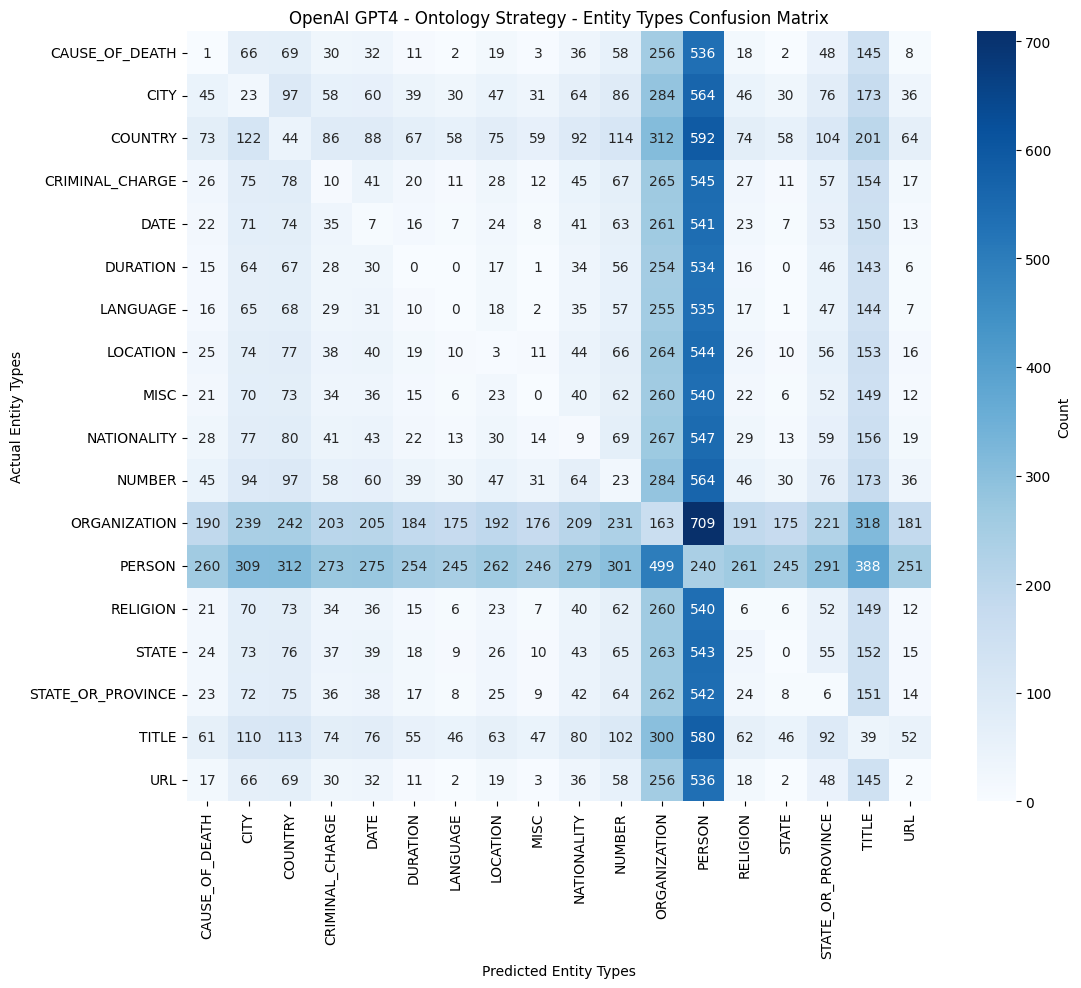

In [38]:
title = "OpenAI GPT4 - Ontology Strategy - Entity Types Confusion Matrix"

openai_ontology_confusion_matrix = create_entity_type_confusion_matrix(openai_ontology_cm_results_df)
plot_entity_type_confusion_matrix(openai_ontology_confusion_matrix, title=title)

### OpenAI GPT4 - Ontology Strategy - Relation Types

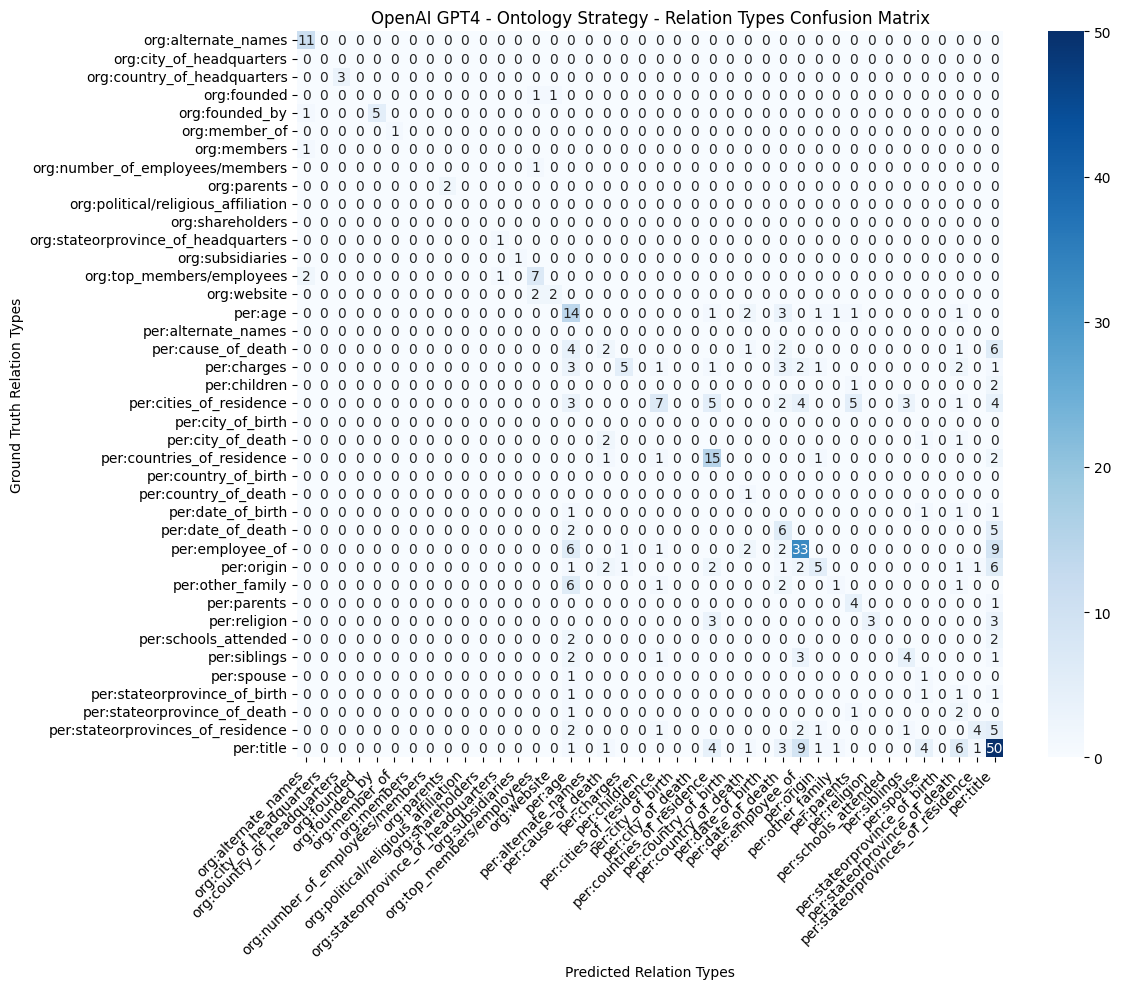

In [43]:
title = "OpenAI GPT4 - Ontology Strategy - Relation Types Confusion Matrix"

openai_ontology_confusion_matrix = create_relation_type_confusion_matrix(openai_ontology_cm_results_df)
plot_relation_type_confusion_matrix(openai_ontology_confusion_matrix, title=title)

### Meta Llama 3.2-3B-Instruct - Ontology Strategy - Entity Types

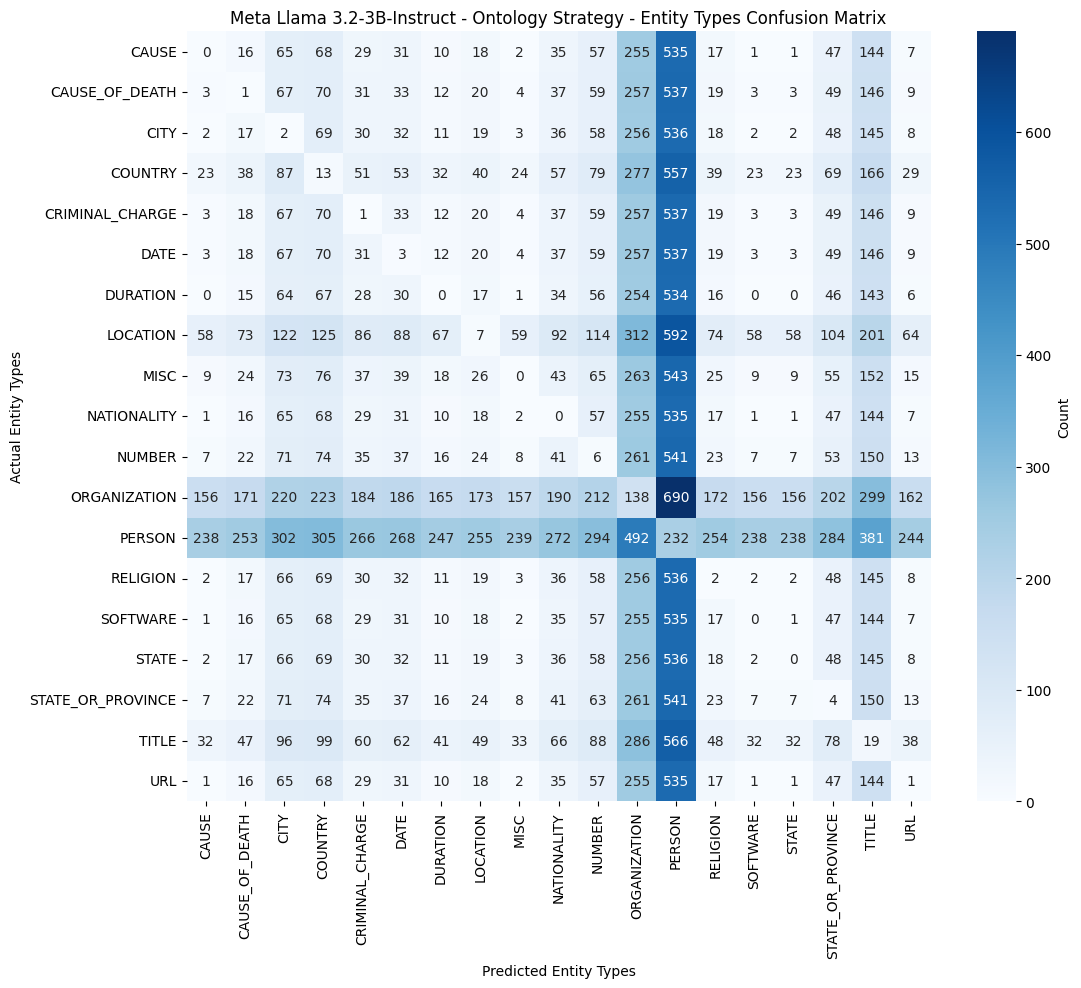

In [45]:
title = "Meta Llama 3.2-3B-Instruct - Ontology Strategy - Entity Types Confusion Matrix"

llama_ontology_confusion_matrix = create_entity_type_confusion_matrix(llama_ontology_cm_results_df)
plot_entity_type_confusion_matrix(llama_ontology_confusion_matrix, title=title)

### Meta Llama 3.2-3B-Instruct - Ontology Strategy - Relation Types

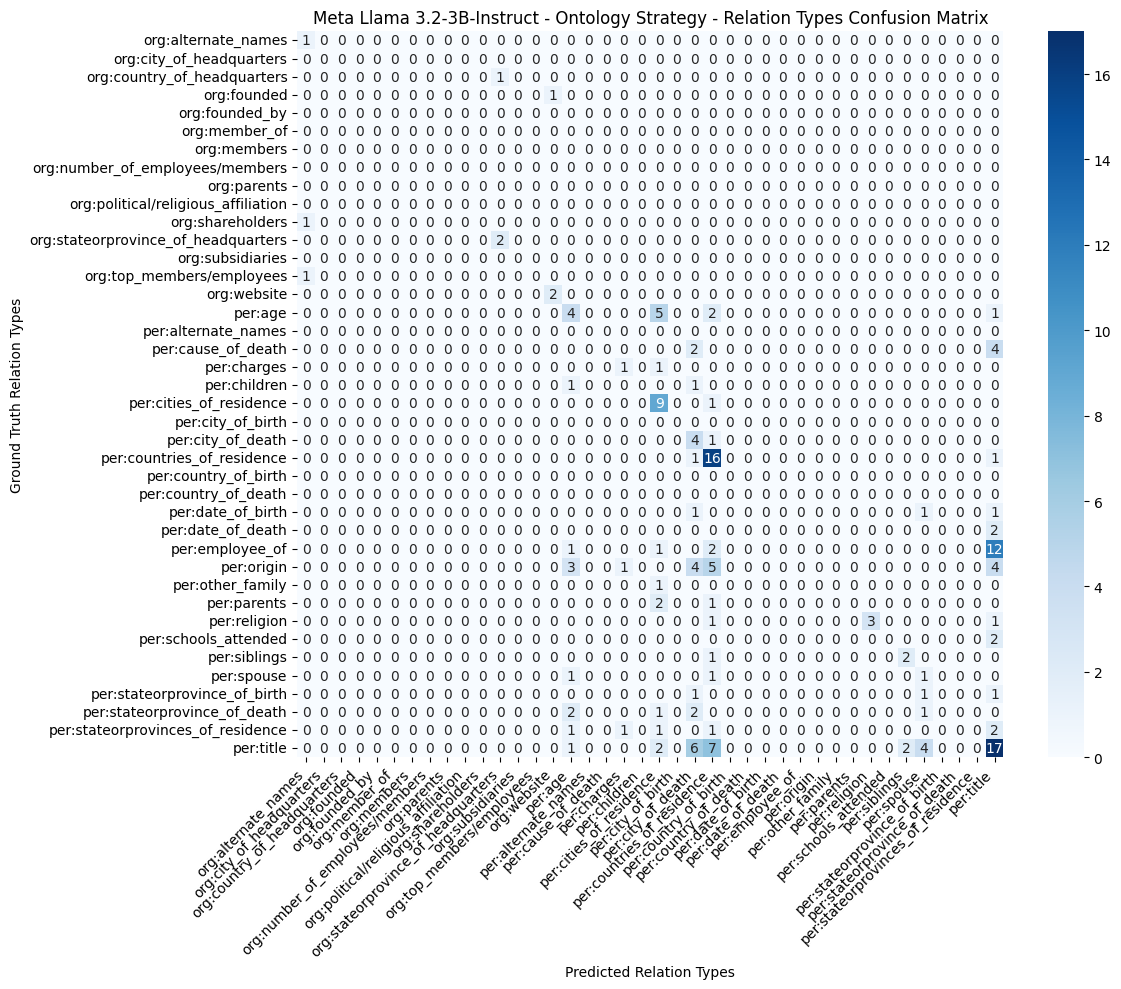

In [47]:
title = "Meta Llama 3.2-3B-Instruct - Ontology Strategy - Relation Types Confusion Matrix"

llama_ontology_confusion_matrix = create_relation_type_confusion_matrix(llama_ontology_cm_results_df)
plot_relation_type_confusion_matrix(llama_ontology_confusion_matrix, title=title)

### OpenAI GPT4 - Chain-Of-Thought (CoT) Strategy - Entity Types

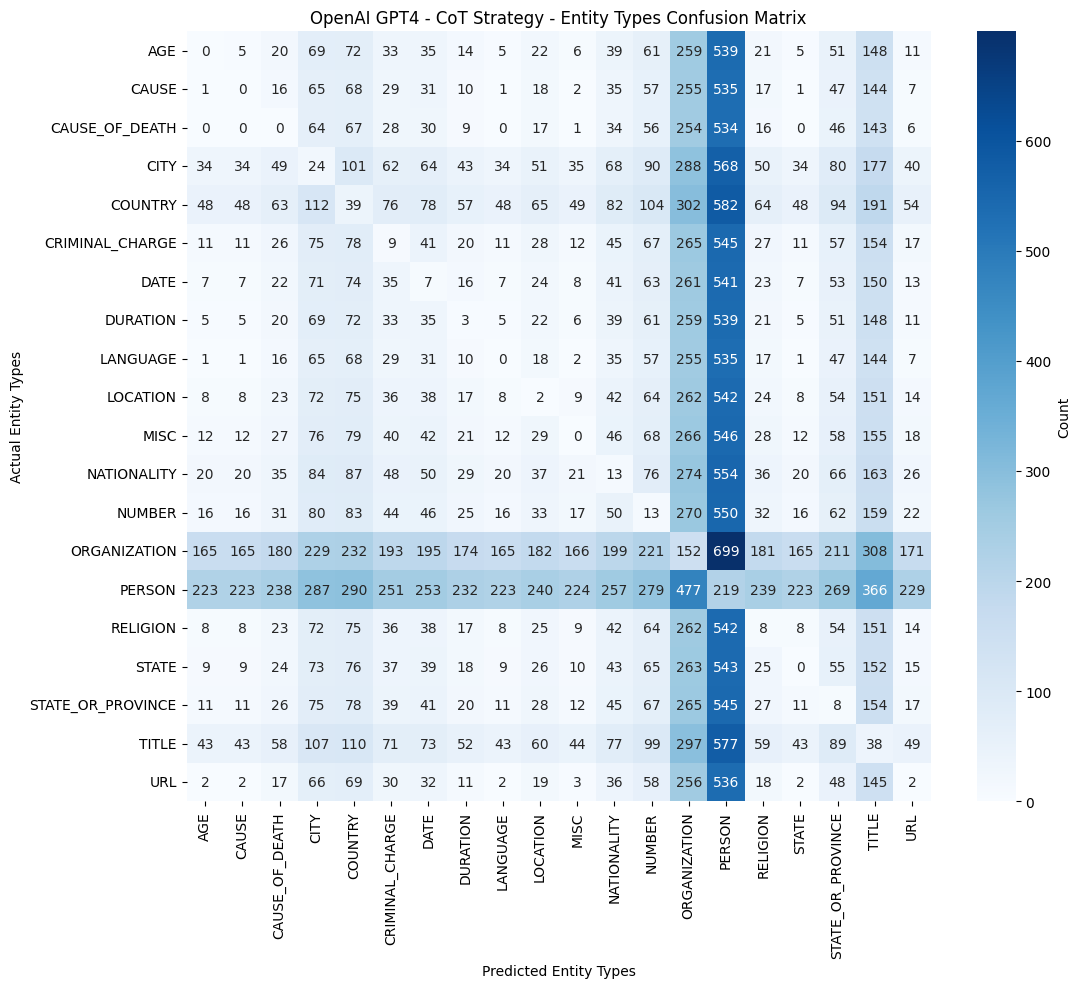

In [49]:
title = "OpenAI GPT4 - CoT Strategy - Entity Types Confusion Matrix"

openai_cot_confusion_matrix = create_entity_type_confusion_matrix(openai_cot_cm_results_df)
plot_entity_type_confusion_matrix(openai_cot_confusion_matrix, title=title)

### OpenAI GPT4 - Chain-Of-Thought (CoT) Strategy - Relationship Types

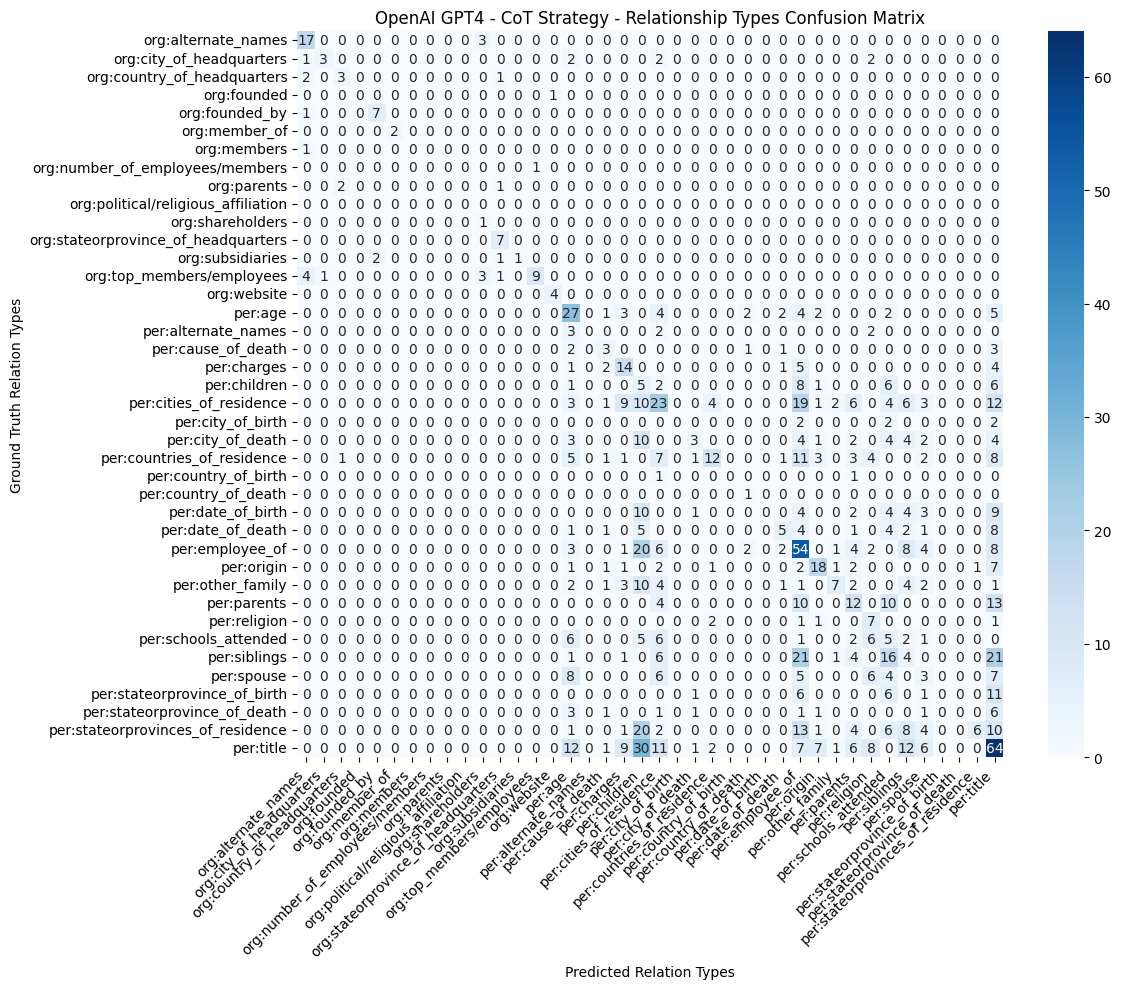

In [51]:
title = "OpenAI GPT4 - CoT Strategy - Relationship Types Confusion Matrix"

openai_cot_confusion_matrix = create_relation_type_confusion_matrix(openai_cot_cm_results_df)
plot_entity_type_confusion_matrix(openai_cot_confusion_matrix, title=title)

### Meta Llama 3.2-3B-Instruct - Chain-Of-Thought (CoT) Strategy - Entity Types

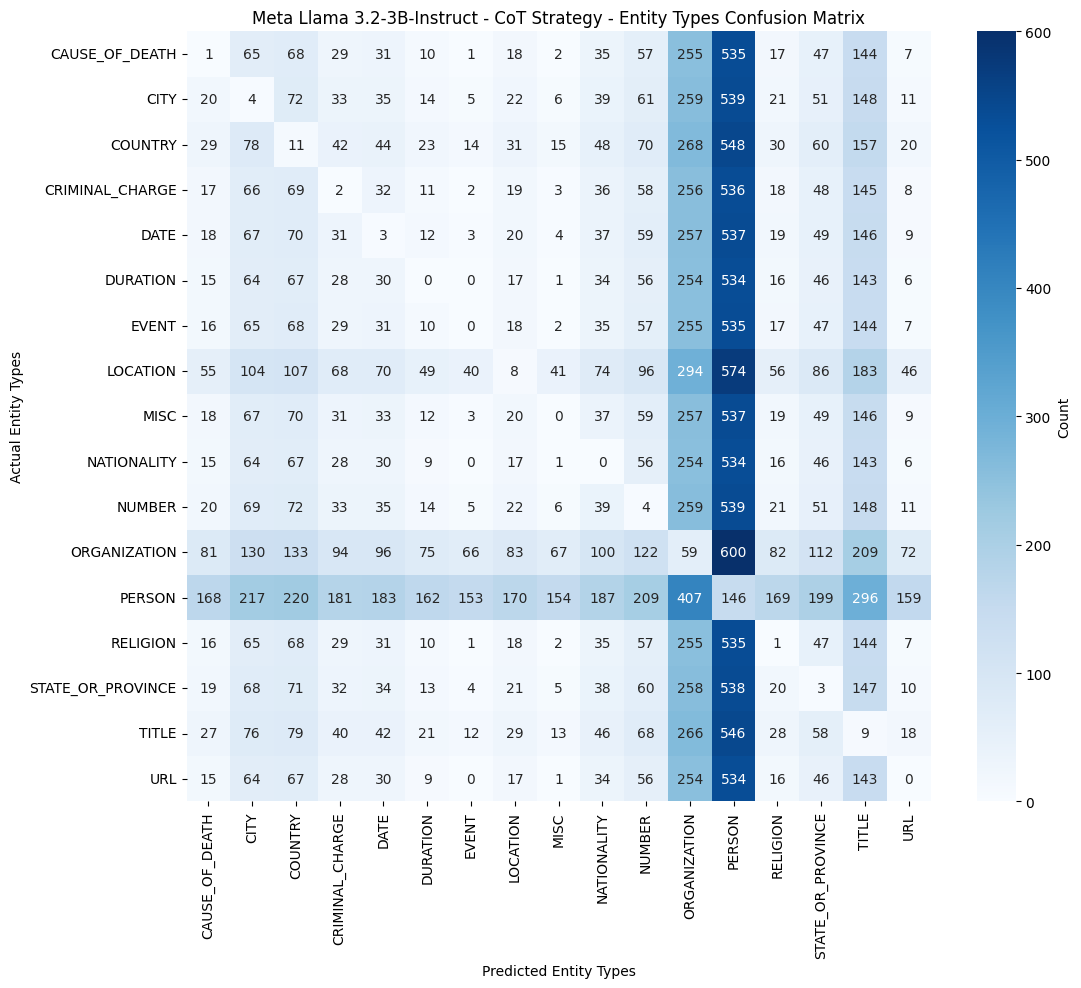

In [55]:
title = "Meta Llama 3.2-3B-Instruct - CoT Strategy - Entity Types Confusion Matrix"

llama_cot_confusion_matrix = create_entity_type_confusion_matrix(llama_cot_cm_results_df)
plot_entity_type_confusion_matrix(llama_cot_confusion_matrix, title=title)

### Meta Llama 3.2-3B-Instruct - Chain-Of-Thought (CoT) Strategy - Relationship Types

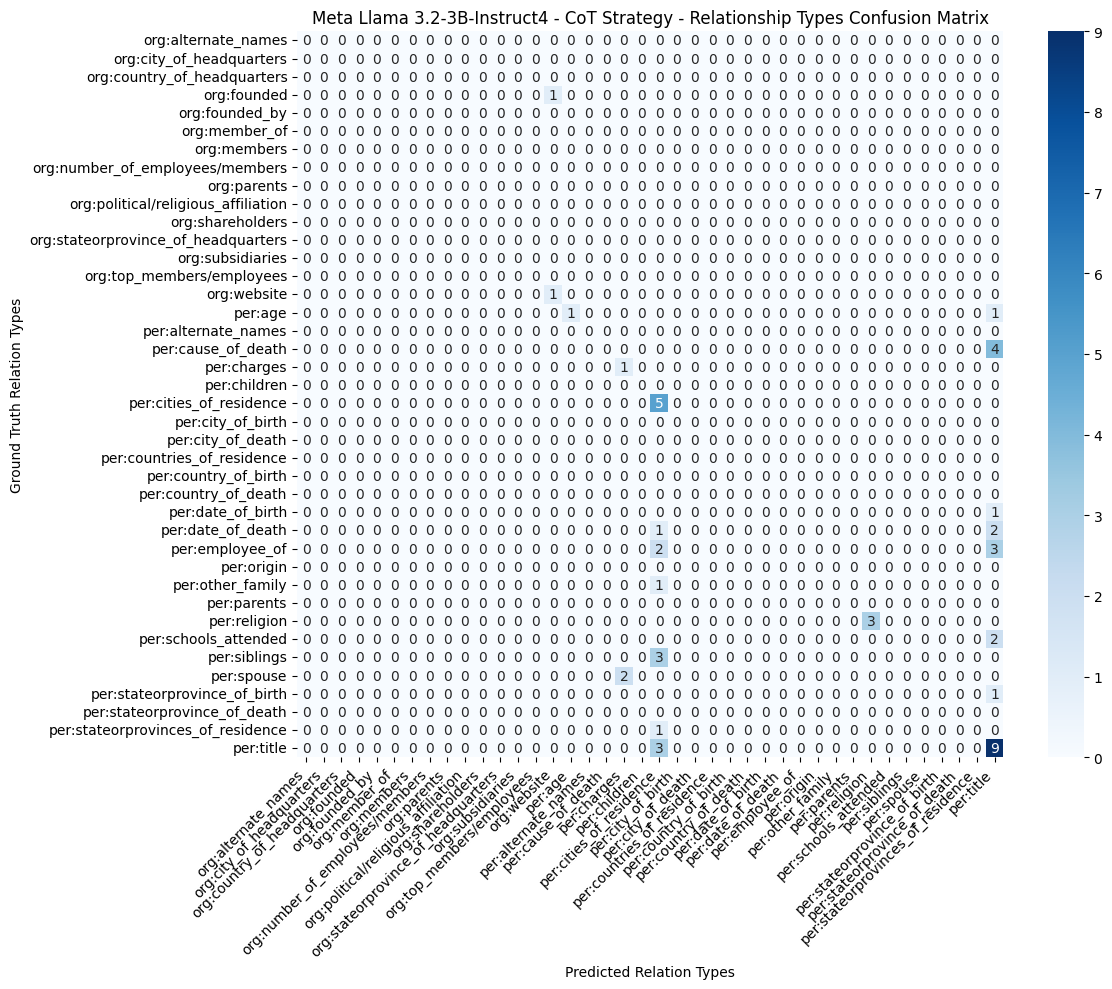

In [52]:
title = "Meta Llama 3.2-3B-Instruct4 - CoT Strategy - Relationship Types Confusion Matrix"

llama_cot_confusion_matrix = create_relation_type_confusion_matrix(llama_cot_cm_results_df)
plot_relation_type_confusion_matrix(llama_cot_confusion_matrix, title=title)

## Entity & Relationship Type Metrics

### Function Definitions

In [59]:
%pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [60]:
from tabulate import tabulate

In [61]:
import pandas as pd
from collections import Counter

def compute_entity_type_metrics(df):
    """
    Compute performance metrics (TP, FP, FN, Precision, Recall, F1) for each entity type.
    """
    # Counters for entity type-level metrics
    tp_counter = Counter()
    fp_counter = Counter()
    fn_counter = Counter()

    for _, row in df.iterrows():
        # Extract ground truth and predicted entity types
        gt_types = [entity[0] for entity in row['gt_entities']]
        pred_types = [entity[0] for entity in row['filtered_semantic_entities']]

        gt_type_set = Counter(gt_types)
        pred_type_set = Counter(pred_types)

        # Compute True Positives (intersection of ground truth and predictions)
        for entity_type in gt_type_set:
            tp_counter[entity_type] += min(gt_type_set[entity_type], pred_type_set.get(entity_type, 0))
        
        # Compute False Positives (predicted but not in ground truth)
        for entity_type in pred_type_set:
            if entity_type not in gt_type_set:
                fp_counter[entity_type] += pred_type_set[entity_type]
            else:
                fp_counter[entity_type] += max(0, pred_type_set[entity_type] - gt_type_set[entity_type])

        # Compute False Negatives (ground truth but not predicted)
        for entity_type in gt_type_set:
            if entity_type not in pred_type_set:
                fn_counter[entity_type] += gt_type_set[entity_type]
            else:
                fn_counter[entity_type] += max(0, gt_type_set[entity_type] - pred_type_set[entity_type])

    # Compute precision, recall, and F1
    metrics = []
    all_types = set(tp_counter.keys()).union(fp_counter.keys()).union(fn_counter.keys())
    for entity_type in all_types:
        tp = tp_counter[entity_type]
        fp = fp_counter[entity_type]
        fn = fn_counter[entity_type]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics.append({
            "Entity Type": entity_type,
            "True Positive (TP)": tp,
            "False Positive (FP)": fp,
            "False Negative (FN)": fn,
            "Precision": precision,
            "Recall": recall,
            "F1": f1
        })

    return pd.DataFrame(metrics)

In [ ]:
import pandas as pd
from collections import Counter

def compute_relation_type_metrics(df):
    metrics = {}

    for _, row in df.iterrows():
        # Extract ground truth and predicted relation types
        gt_rel_types = [rel[0][1] for rel in row['gt_relationships']]  # Extract the relation type (e.g., 'per:age')
        pred_rel_types = [rel[0][1] for rel in row['filtered_semantic_relationships']]  # Extract predicted relation type

        # Count occurrences of each relation type
        gt_rel_set = Counter(gt_rel_types)
        pred_rel_set = Counter(pred_rel_types)

        for rel_type in set(gt_rel_types + pred_rel_types):
            if rel_type not in metrics:
                metrics[rel_type] = {'TP': 0, 'FP': 0, 'FN': 0}

            # True Positives: Count of correctly predicted relations
            tp = min(gt_rel_set.get(rel_type, 0), pred_rel_set.get(rel_type, 0))
            metrics[rel_type]['TP'] += tp

            # False Positives: Predicted relations that don't match ground truth
            fp = pred_rel_set.get(rel_type, 0) - tp
            metrics[rel_type]['FP'] += fp

            # False Negatives: Ground truth relations that were not predicted
            fn = gt_rel_set.get(rel_type, 0) - tp
            metrics[rel_type]['FN'] += fn

    # Calculate Precision, Recall, and F1 Score
    for rel_type, counts in metrics.items():
        tp = counts['TP']
        fp = counts['FP']
        fn = counts['FN']
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
        counts['Precision'] = precision
        counts['Recall'] = recall
        counts['F1'] = f1

    # Convert metrics to DataFrame for better visualization
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index').reset_index()
    metrics_df.rename(columns={'index': 'Relation Type'}, inplace=True)

    return metrics_df

### Meta Llama 3.2-3B-Instruct - Ontology Strategy - Entity Type Metrics

In [62]:
# Compute metrics
llama_ontology_entity_metrics = compute_entity_type_metrics(llama_ontology_cm_results_df)

# Generate a tabulated version of the DataFrame
table = tabulate(llama_ontology_entity_metrics, headers='keys', tablefmt='grid', showindex=False)

# Print the table
print(table)

+-------------------+----------------------+-----------------------+-----------------------+-------------+-----------+-----------+
| Entity Type       |   True Positive (TP) |   False Positive (FP) |   False Negative (FN) |   Precision |    Recall |        F1 |
+===================+======================+=======================+=======================+=============+===========+===========+
| PERSON            |                  232 |                     6 |                   302 |    0.97479  | 0.434457  | 0.601036  |
+-------------------+----------------------+-----------------------+-----------------------+-------------+-----------+-----------+
| RELIGION          |                    2 |                     0 |                    14 |    1        | 0.125     | 0.222222  |
+-------------------+----------------------+-----------------------+-----------------------+-------------+-----------+-----------+
| CITY              |                    2 |                     0 |               

### OpenAI GPT4 - CoT Strategy - Relationship Type Metrics

In [64]:
# Compute metrics
openai_cot_relationship_metrics = compute_relation_type_metrics(llama_ontology_cm_results_df)

# Generate a tabulated version of the DataFrame
table = tabulate(openai_cot_relationship_metrics, headers='keys', tablefmt='grid', showindex=False)

# Print the table
print(table)

+-------------------------------------+------+------+------+-------------+-----------+-----------+
| Relation Type                       |   TP |   FP |   FN |   Precision |    Recall |        F1 |
+=====================================+======+======+======+=============+===========+===========+
| org:founded_by                      |    0 |    0 |    9 |    0        | 0         | 0         |
+-------------------------------------+------+------+------+-------------+-----------+-----------+
| per:countries_of_residence          |   13 |    1 |   40 |    0.928571 | 0.245283  | 0.38806   |
+-------------------------------------+------+------+------+-------------+-----------+-----------+
| per:stateorprovinces_of_residence   |    0 |    0 |   33 |    0        | 0         | 0         |
+-------------------------------------+------+------+------+-------------+-----------+-----------+
| per:cities_of_residence             |    6 |    0 |   63 |    1        | 0.0869565 | 0.16      |
+---------

## Composite Bar Metrics

### Function Definitions

In [76]:
import matplotlib.pyplot as plt
import numpy as np

def plot_composite_bar_metric(title, name_df_pairs, metrics):
    """
    Plots a composite bar chart for a list of (name, dataframe) pairs.

    Args:
        title (str): The title of the plot.
        name_df_pairs (list): A list of tuples (name, dataframe), where:
                              - name (str): Algorithm or model name.
                              - dataframe (pd.DataFrame): DataFrame containing the metrics.
        metrics (list): A list of metric names (str) to extract and plot from each DataFrame.
    """
    # Initialize variables for plotting
    n_groups = len(name_df_pairs)  # Number of clusters
    n_metrics = len(metrics)       # Number of bars per cluster
    index = np.arange(n_groups)    # Indices for clusters
    bar_width = 0.8 / n_metrics    # Width of each bar
    
    # Colors for metrics
    colors = plt.cm.Blues(np.linspace(0.4, 0.9, n_metrics))
    # Set up the figure
    plt.figure(figsize=(10, 6))
    
    # Plot each metric as a separate bar in the cluster
    for i, metric in enumerate(metrics):
        values = [
            df[metric].mean() if metric in df.columns else 0  # Use mean or default 0
            for _, df in name_df_pairs
        ]
        plt.bar(index + i * bar_width, values, bar_width, label=metric, color=colors[i])
    
    # Set the x-ticks and labels
    plt.xticks(index + bar_width * (n_metrics - 1) / 2, [name for name, _ in name_df_pairs], rotation=0)
    plt.title(title)
    plt.ylabel("Metric Values")
    plt.legend(title="Metrics")
    plt.tight_layout()
    plt.show()


### Composite Plots

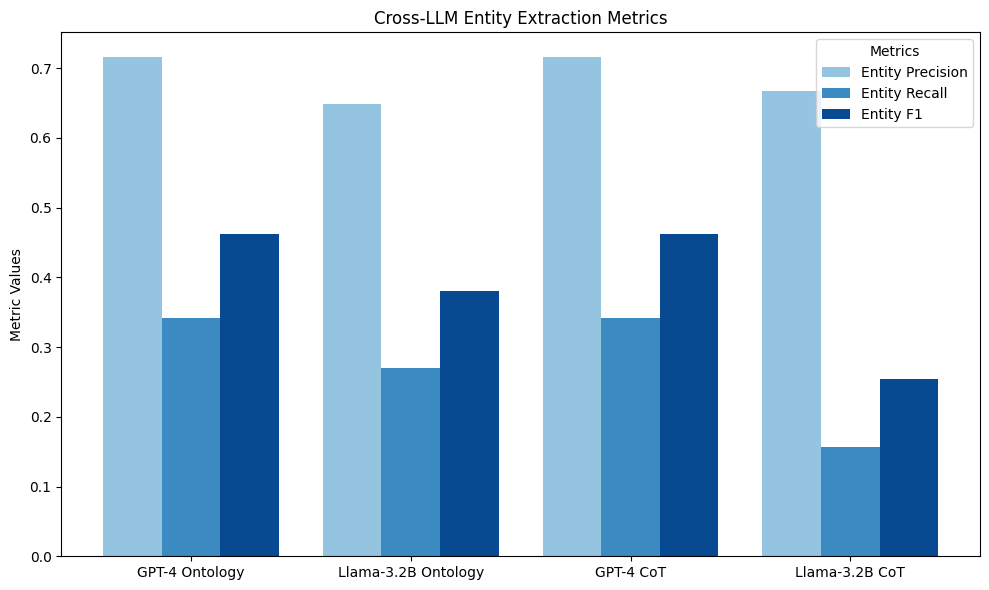

In [80]:
# Cross-LLM Entity Extraction Metrics

name_df_pairs = [
    ("GPT-4 Ontology", openai_ontology_cm_metrics_df),
    ("Llama-3.2B Ontology", llama_ontology_cm_metrics_df),
    ("GPT-4 CoT", openai_cot_cm_metrics_df),
    ("Llama-3.2B CoT", llama_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["Entity Precision", "Entity Recall", "Entity F1"]

# Call the function
plot_composite_bar_metric("Cross-LLM Entity Extraction Metrics", name_df_pairs, metrics)

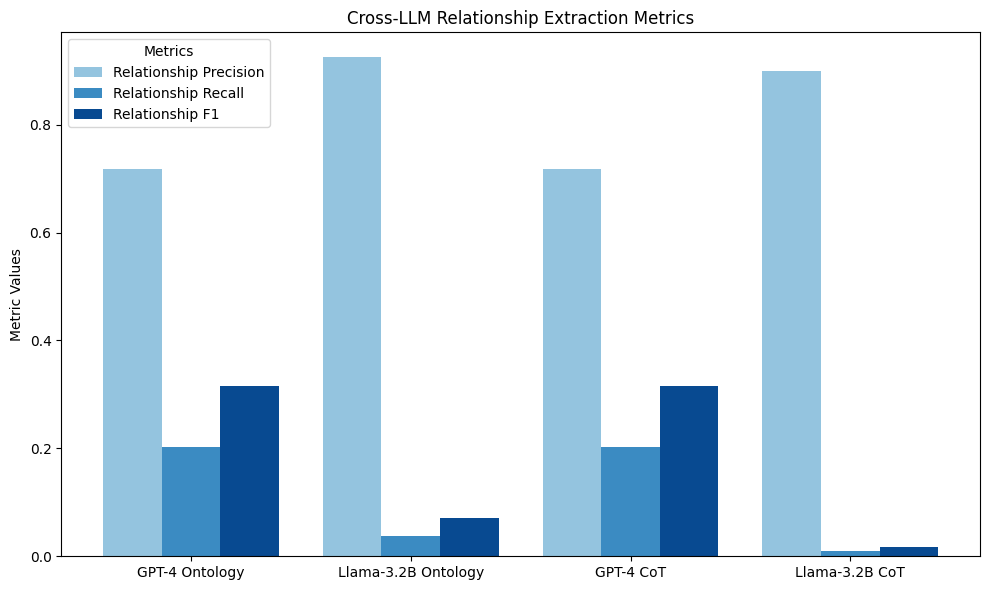

In [81]:
# Cross-LLM Relationship Extraction Metrics

name_df_pairs = [
    ("GPT-4 Ontology", openai_ontology_cm_metrics_df),
    ("Llama-3.2B Ontology", llama_ontology_cm_metrics_df),
    ("GPT-4 CoT", openai_cot_cm_metrics_df),
    ("Llama-3.2B CoT", llama_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["Relationship Precision", "Relationship Recall", "Relationship F1"]

# Call the function
plot_composite_bar_metric("Cross-LLM Relationship Extraction Metrics", name_df_pairs, metrics)

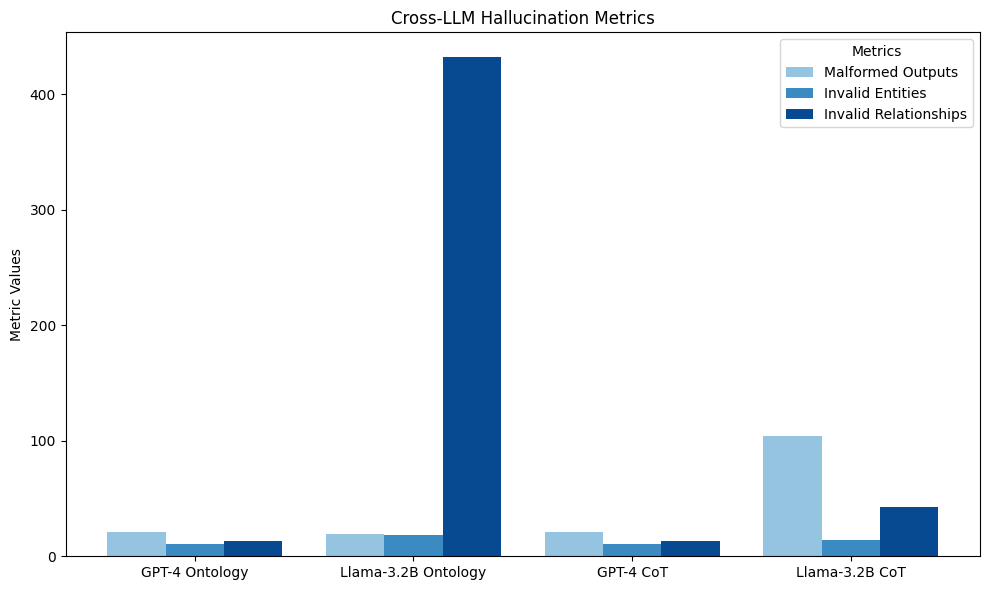

In [82]:
# Cross-LLM Relationshipt Extraction Metrics

name_df_pairs = [
    ("GPT-4 Ontology", openai_ontology_cm_metrics_df),
    ("Llama-3.2B Ontology", llama_ontology_cm_metrics_df),
    ("GPT-4 CoT", openai_cot_cm_metrics_df),
    ("Llama-3.2B CoT", llama_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["Malformed Outputs", "Invalid Entities", "Invalid Relationships"]

# Call the function
plot_composite_bar_metric("Cross-LLM Hallucination Metrics", name_df_pairs, metrics)

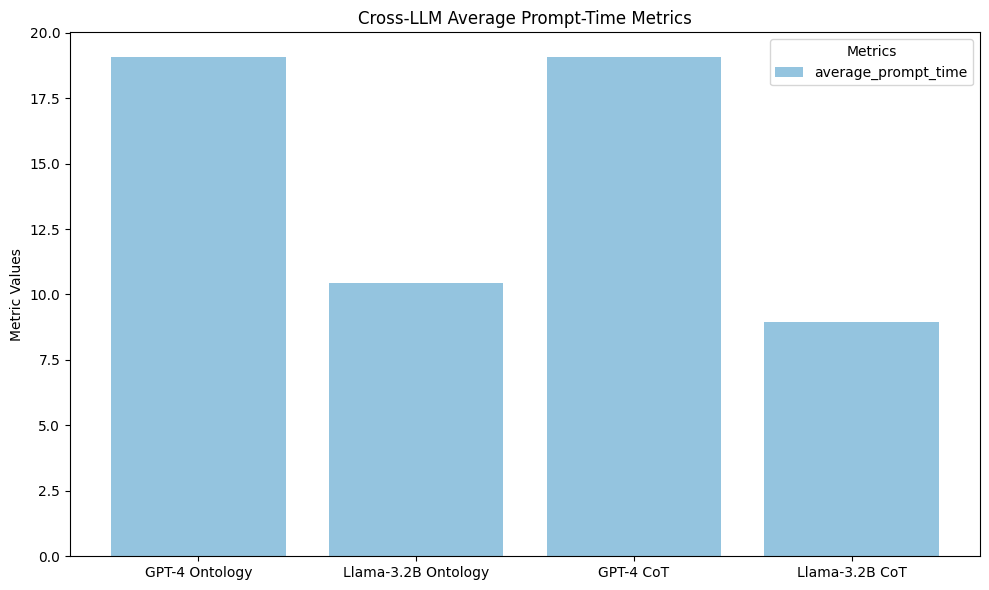

In [83]:
# Cross-LLM Average Prompt Time Metrics

name_df_pairs = [
    ("GPT-4 Ontology", openai_ontology_cm_metrics_df),
    ("Llama-3.2B Ontology", llama_ontology_cm_metrics_df),
    ("GPT-4 CoT", openai_cot_cm_metrics_df),
    ("Llama-3.2B CoT", llama_cot_cm_metrics_df),   
]

# List of metrics to visualize
metrics = ["average_prompt_time"]

# Call the function
plot_composite_bar_metric("Cross-LLM Average Prompt-Time Metrics", name_df_pairs, metrics)